In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
fs_type = 'full'

In [4]:
# Parameters
fs_type = "uni85"


In [5]:
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 264
Categorical features: 8
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=False if fs_type=="full" else True,
    include_text_features=False,
)

text_cols = list()

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 336
Categorical Columns: 8


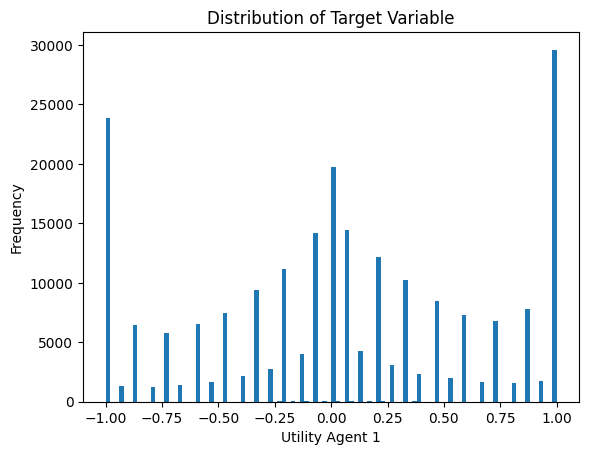

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [9]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {

        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        'bagging_temperature' : 0.50,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            # data=X_train[numerical_cols + categorical_cols + text_cols],
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            # data=X_valid[numerical_cols + categorical_cols + text_cols],
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1


0:	learn: 0.6112569	test: 0.5506954	best: 0.5506954 (0)	total: 159ms	remaining: 7m 58s


50:	learn: 0.3812478	test: 0.4614325	best: 0.4614325 (50)	total: 5.13s	remaining: 4m 56s


100:	learn: 0.3423412	test: 0.4461055	best: 0.4461055 (100)	total: 10.2s	remaining: 4m 53s


150:	learn: 0.3179387	test: 0.4365900	best: 0.4365900 (150)	total: 15.3s	remaining: 4m 47s


200:	learn: 0.3030467	test: 0.4322874	best: 0.4322874 (200)	total: 20.7s	remaining: 4m 47s


250:	learn: 0.2905174	test: 0.4294189	best: 0.4294189 (250)	total: 25.7s	remaining: 4m 41s


300:	learn: 0.2812187	test: 0.4282388	best: 0.4282388 (300)	total: 30.8s	remaining: 4m 35s


350:	learn: 0.2734505	test: 0.4269442	best: 0.4269442 (350)	total: 35.9s	remaining: 4m 31s


400:	learn: 0.2672001	test: 0.4264316	best: 0.4264184 (394)	total: 41.1s	remaining: 4m 26s


450:	learn: 0.2614311	test: 0.4256568	best: 0.4256568 (450)	total: 46.3s	remaining: 4m 21s


500:	learn: 0.2564626	test: 0.4253175	best: 0.4253175 (500)	total: 51.5s	remaining: 4m 16s


550:	learn: 0.2515409	test: 0.4247378	best: 0.4247378 (550)	total: 56.6s	remaining: 4m 11s


600:	learn: 0.2467598	test: 0.4237742	best: 0.4237561 (597)	total: 1m 1s	remaining: 4m 6s


650:	learn: 0.2424306	test: 0.4234616	best: 0.4234281 (645)	total: 1m 6s	remaining: 4m


700:	learn: 0.2391050	test: 0.4231680	best: 0.4231526 (678)	total: 1m 11s	remaining: 3m 55s


750:	learn: 0.2357329	test: 0.4230308	best: 0.4229170 (728)	total: 1m 16s	remaining: 3m 50s


800:	learn: 0.2324481	test: 0.4228054	best: 0.4227509 (781)	total: 1m 22s	remaining: 3m 45s


850:	learn: 0.2294698	test: 0.4227666	best: 0.4227509 (781)	total: 1m 27s	remaining: 3m 39s


900:	learn: 0.2263383	test: 0.4223712	best: 0.4223712 (900)	total: 1m 32s	remaining: 3m 34s


950:	learn: 0.2236162	test: 0.4224057	best: 0.4223576 (901)	total: 1m 37s	remaining: 3m 29s


1000:	learn: 0.2211219	test: 0.4223206	best: 0.4222872 (993)	total: 1m 42s	remaining: 3m 24s


1050:	learn: 0.2185891	test: 0.4221033	best: 0.4220611 (1044)	total: 1m 47s	remaining: 3m 19s


1100:	learn: 0.2164788	test: 0.4220475	best: 0.4219376 (1086)	total: 1m 52s	remaining: 3m 14s


1150:	learn: 0.2141781	test: 0.4218879	best: 0.4218098 (1139)	total: 1m 57s	remaining: 3m 9s


1200:	learn: 0.2118556	test: 0.4219819	best: 0.4218098 (1139)	total: 2m 2s	remaining: 3m 3s


1250:	learn: 0.2098415	test: 0.4216756	best: 0.4216667 (1249)	total: 2m 8s	remaining: 2m 59s


1300:	learn: 0.2078198	test: 0.4216362	best: 0.4216362 (1300)	total: 2m 13s	remaining: 2m 53s


1350:	learn: 0.2057599	test: 0.4216414	best: 0.4216134 (1305)	total: 2m 18s	remaining: 2m 48s


1400:	learn: 0.2037354	test: 0.4217131	best: 0.4216134 (1305)	total: 2m 23s	remaining: 2m 43s


1450:	learn: 0.2018907	test: 0.4217907	best: 0.4216134 (1305)	total: 2m 28s	remaining: 2m 38s


1500:	learn: 0.2002390	test: 0.4217855	best: 0.4216134 (1305)	total: 2m 33s	remaining: 2m 33s


1550:	learn: 0.1985103	test: 0.4218288	best: 0.4216134 (1305)	total: 2m 38s	remaining: 2m 27s


1600:	learn: 0.1968315	test: 0.4217923	best: 0.4216134 (1305)	total: 2m 43s	remaining: 2m 22s


1650:	learn: 0.1951109	test: 0.4218354	best: 0.4216134 (1305)	total: 2m 48s	remaining: 2m 17s


1700:	learn: 0.1934799	test: 0.4218399	best: 0.4216134 (1305)	total: 2m 53s	remaining: 2m 12s


1750:	learn: 0.1918744	test: 0.4217867	best: 0.4216134 (1305)	total: 2m 58s	remaining: 2m 7s


1800:	learn: 0.1904034	test: 0.4217095	best: 0.4216134 (1305)	total: 3m 3s	remaining: 2m 2s


1850:	learn: 0.1889886	test: 0.4217194	best: 0.4216134 (1305)	total: 3m 8s	remaining: 1m 57s


1900:	learn: 0.1875064	test: 0.4216860	best: 0.4216134 (1305)	total: 3m 14s	remaining: 1m 52s


1950:	learn: 0.1859771	test: 0.4217247	best: 0.4216134 (1305)	total: 3m 19s	remaining: 1m 47s


2000:	learn: 0.1845458	test: 0.4217710	best: 0.4216134 (1305)	total: 3m 24s	remaining: 1m 41s


2050:	learn: 0.1831696	test: 0.4217065	best: 0.4216134 (1305)	total: 3m 29s	remaining: 1m 36s


2100:	learn: 0.1816440	test: 0.4217420	best: 0.4216134 (1305)	total: 3m 34s	remaining: 1m 31s


2150:	learn: 0.1801919	test: 0.4218331	best: 0.4216134 (1305)	total: 3m 39s	remaining: 1m 26s


2200:	learn: 0.1788099	test: 0.4218606	best: 0.4216134 (1305)	total: 3m 44s	remaining: 1m 21s


2250:	learn: 0.1775342	test: 0.4218680	best: 0.4216134 (1305)	total: 3m 49s	remaining: 1m 16s


2300:	learn: 0.1761715	test: 0.4218369	best: 0.4216134 (1305)	total: 3m 54s	remaining: 1m 11s


2350:	learn: 0.1748135	test: 0.4217943	best: 0.4216134 (1305)	total: 3m 59s	remaining: 1m 6s


2400:	learn: 0.1735278	test: 0.4217642	best: 0.4216134 (1305)	total: 4m 4s	remaining: 1m 1s


2450:	learn: 0.1724775	test: 0.4217160	best: 0.4216134 (1305)	total: 4m 10s	remaining: 56s


2500:	learn: 0.1712463	test: 0.4217425	best: 0.4216134 (1305)	total: 4m 15s	remaining: 50.9s


2550:	learn: 0.1700464	test: 0.4217775	best: 0.4216134 (1305)	total: 4m 20s	remaining: 45.8s


2600:	learn: 0.1690305	test: 0.4217496	best: 0.4216134 (1305)	total: 4m 25s	remaining: 40.8s


2650:	learn: 0.1678737	test: 0.4217731	best: 0.4216134 (1305)	total: 4m 30s	remaining: 35.7s


2700:	learn: 0.1667080	test: 0.4218220	best: 0.4216134 (1305)	total: 4m 35s	remaining: 30.5s


2750:	learn: 0.1656124	test: 0.4218058	best: 0.4216134 (1305)	total: 4m 41s	remaining: 25.4s


2800:	learn: 0.1644009	test: 0.4218283	best: 0.4216134 (1305)	total: 4m 46s	remaining: 20.3s


2850:	learn: 0.1633663	test: 0.4218386	best: 0.4216134 (1305)	total: 4m 51s	remaining: 15.2s


2900:	learn: 0.1622776	test: 0.4218766	best: 0.4216134 (1305)	total: 4m 56s	remaining: 10.1s


2950:	learn: 0.1611888	test: 0.4219475	best: 0.4216134 (1305)	total: 5m 1s	remaining: 5s


2999:	learn: 0.1602292	test: 0.4219233	best: 0.4216134 (1305)	total: 5m 6s	remaining: 0us

bestTest = 0.4216133803
bestIteration = 1305

Shrink model to first 1306 iterations.


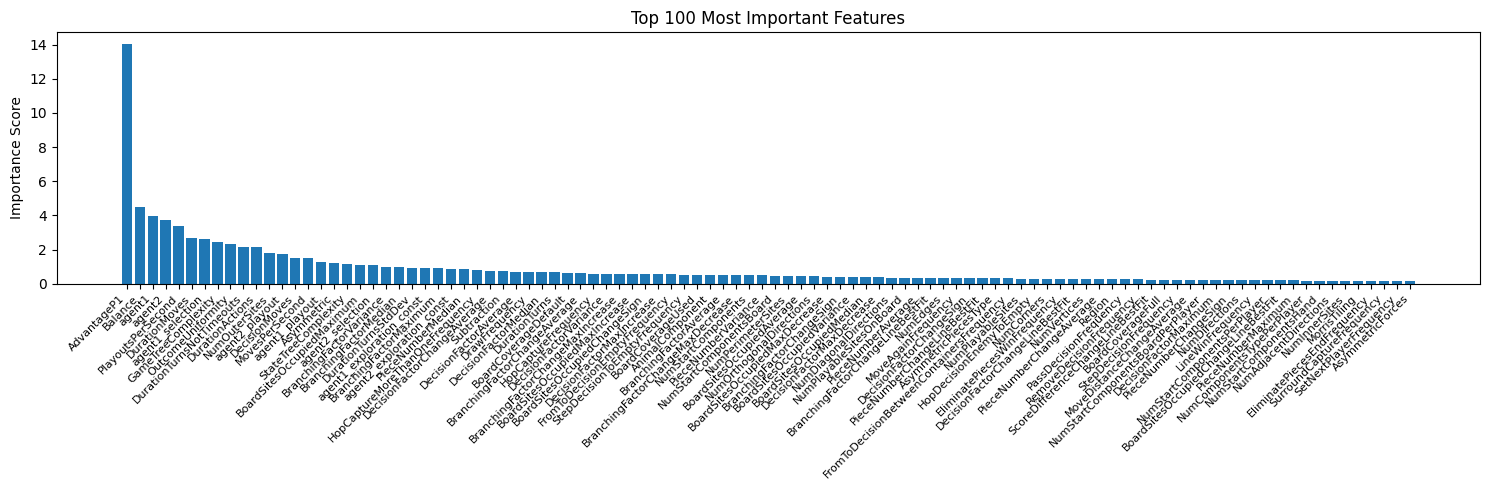

Fold 1 - RMSE: 0.42107816773911977
Fold 2


0:	learn: 0.6066394	test: 0.5808339	best: 0.5808339 (0)	total: 91.3ms	remaining: 4m 33s


50:	learn: 0.3877612	test: 0.4703427	best: 0.4703427 (50)	total: 4.98s	remaining: 4m 47s


100:	learn: 0.3471718	test: 0.4537436	best: 0.4537436 (100)	total: 10.2s	remaining: 4m 52s


150:	learn: 0.3245233	test: 0.4469280	best: 0.4469280 (150)	total: 15.3s	remaining: 4m 48s


200:	learn: 0.3091867	test: 0.4421193	best: 0.4421193 (200)	total: 20.5s	remaining: 4m 45s


250:	learn: 0.2976615	test: 0.4403893	best: 0.4403893 (250)	total: 25.8s	remaining: 4m 42s


300:	learn: 0.2882738	test: 0.4392302	best: 0.4391898 (299)	total: 31s	remaining: 4m 38s


350:	learn: 0.2799240	test: 0.4372129	best: 0.4372129 (350)	total: 36.2s	remaining: 4m 33s


400:	learn: 0.2729713	test: 0.4366145	best: 0.4366145 (400)	total: 41.4s	remaining: 4m 28s


450:	learn: 0.2665662	test: 0.4357925	best: 0.4357925 (450)	total: 46.6s	remaining: 4m 23s


500:	learn: 0.2614206	test: 0.4354087	best: 0.4354087 (500)	total: 51.7s	remaining: 4m 17s


550:	learn: 0.2567600	test: 0.4351340	best: 0.4351340 (550)	total: 56.9s	remaining: 4m 12s


600:	learn: 0.2524147	test: 0.4350114	best: 0.4349707 (591)	total: 1m 2s	remaining: 4m 8s


650:	learn: 0.2481280	test: 0.4347539	best: 0.4347023 (644)	total: 1m 7s	remaining: 4m 3s


700:	learn: 0.2445740	test: 0.4345718	best: 0.4345674 (698)	total: 1m 12s	remaining: 3m 58s


750:	learn: 0.2409142	test: 0.4345726	best: 0.4344503 (735)	total: 1m 17s	remaining: 3m 53s


800:	learn: 0.2381415	test: 0.4344322	best: 0.4343957 (797)	total: 1m 23s	remaining: 3m 48s


850:	learn: 0.2353765	test: 0.4342331	best: 0.4342258 (847)	total: 1m 28s	remaining: 3m 42s


900:	learn: 0.2326814	test: 0.4340966	best: 0.4340728 (875)	total: 1m 33s	remaining: 3m 37s


950:	learn: 0.2297381	test: 0.4338279	best: 0.4338014 (946)	total: 1m 38s	remaining: 3m 32s


1000:	learn: 0.2271665	test: 0.4337202	best: 0.4337181 (999)	total: 1m 43s	remaining: 3m 27s


1050:	learn: 0.2245386	test: 0.4334219	best: 0.4334112 (1048)	total: 1m 49s	remaining: 3m 22s


1100:	learn: 0.2221231	test: 0.4331641	best: 0.4331102 (1094)	total: 1m 54s	remaining: 3m 17s


1150:	learn: 0.2199510	test: 0.4331738	best: 0.4331102 (1094)	total: 1m 59s	remaining: 3m 12s


1200:	learn: 0.2178042	test: 0.4330597	best: 0.4330597 (1200)	total: 2m 5s	remaining: 3m 7s


1250:	learn: 0.2157367	test: 0.4329023	best: 0.4328968 (1248)	total: 2m 10s	remaining: 3m 2s


1300:	learn: 0.2138402	test: 0.4328676	best: 0.4328481 (1297)	total: 2m 15s	remaining: 2m 57s


1350:	learn: 0.2118095	test: 0.4327649	best: 0.4327649 (1350)	total: 2m 20s	remaining: 2m 51s


1400:	learn: 0.2099164	test: 0.4325668	best: 0.4325642 (1398)	total: 2m 26s	remaining: 2m 46s


1450:	learn: 0.2079501	test: 0.4325248	best: 0.4325075 (1432)	total: 2m 31s	remaining: 2m 41s


1500:	learn: 0.2061870	test: 0.4324478	best: 0.4324177 (1483)	total: 2m 36s	remaining: 2m 36s


1550:	learn: 0.2044673	test: 0.4323579	best: 0.4323574 (1549)	total: 2m 42s	remaining: 2m 31s


1600:	learn: 0.2028165	test: 0.4323288	best: 0.4323126 (1582)	total: 2m 47s	remaining: 2m 26s


1650:	learn: 0.2010995	test: 0.4321930	best: 0.4321813 (1645)	total: 2m 52s	remaining: 2m 21s


1700:	learn: 0.1996125	test: 0.4321628	best: 0.4321207 (1682)	total: 2m 57s	remaining: 2m 15s


1750:	learn: 0.1981588	test: 0.4321142	best: 0.4320925 (1744)	total: 3m 3s	remaining: 2m 10s


1800:	learn: 0.1966883	test: 0.4321380	best: 0.4320925 (1744)	total: 3m 8s	remaining: 2m 5s


1850:	learn: 0.1950658	test: 0.4321190	best: 0.4320917 (1844)	total: 3m 13s	remaining: 2m


1900:	learn: 0.1934143	test: 0.4320420	best: 0.4320420 (1900)	total: 3m 19s	remaining: 1m 55s


1950:	learn: 0.1919306	test: 0.4319231	best: 0.4319231 (1950)	total: 3m 24s	remaining: 1m 49s


2000:	learn: 0.1904120	test: 0.4319222	best: 0.4318892 (1968)	total: 3m 29s	remaining: 1m 44s


2050:	learn: 0.1888978	test: 0.4318947	best: 0.4318891 (2046)	total: 3m 34s	remaining: 1m 39s


2100:	learn: 0.1874443	test: 0.4318087	best: 0.4318062 (2087)	total: 3m 40s	remaining: 1m 34s


2150:	learn: 0.1860933	test: 0.4318037	best: 0.4317829 (2134)	total: 3m 45s	remaining: 1m 28s


2200:	learn: 0.1846791	test: 0.4318229	best: 0.4317737 (2187)	total: 3m 50s	remaining: 1m 23s


2250:	learn: 0.1832950	test: 0.4317742	best: 0.4317473 (2238)	total: 3m 56s	remaining: 1m 18s


2300:	learn: 0.1819807	test: 0.4318309	best: 0.4317473 (2238)	total: 4m 1s	remaining: 1m 13s


2350:	learn: 0.1807729	test: 0.4317707	best: 0.4317473 (2238)	total: 4m 6s	remaining: 1m 8s


2400:	learn: 0.1795475	test: 0.4318489	best: 0.4317473 (2238)	total: 4m 12s	remaining: 1m 2s


2450:	learn: 0.1783455	test: 0.4318636	best: 0.4317473 (2238)	total: 4m 17s	remaining: 57.7s


2500:	learn: 0.1770904	test: 0.4318573	best: 0.4317473 (2238)	total: 4m 22s	remaining: 52.4s


2550:	learn: 0.1759404	test: 0.4318521	best: 0.4317473 (2238)	total: 4m 28s	remaining: 47.2s


2600:	learn: 0.1748191	test: 0.4318395	best: 0.4317473 (2238)	total: 4m 33s	remaining: 41.9s


2650:	learn: 0.1737186	test: 0.4318637	best: 0.4317473 (2238)	total: 4m 38s	remaining: 36.7s


2700:	learn: 0.1725632	test: 0.4318476	best: 0.4317473 (2238)	total: 4m 43s	remaining: 31.4s


2750:	learn: 0.1714686	test: 0.4318927	best: 0.4317473 (2238)	total: 4m 49s	remaining: 26.2s


2800:	learn: 0.1704021	test: 0.4318695	best: 0.4317473 (2238)	total: 4m 54s	remaining: 20.9s


2850:	learn: 0.1692929	test: 0.4319272	best: 0.4317473 (2238)	total: 4m 59s	remaining: 15.7s


2900:	learn: 0.1680841	test: 0.4319338	best: 0.4317473 (2238)	total: 5m 4s	remaining: 10.4s


2950:	learn: 0.1670230	test: 0.4319499	best: 0.4317473 (2238)	total: 5m 10s	remaining: 5.15s


2999:	learn: 0.1660320	test: 0.4320143	best: 0.4317473 (2238)	total: 5m 15s	remaining: 0us

bestTest = 0.4317473351
bestIteration = 2238

Shrink model to first 2239 iterations.


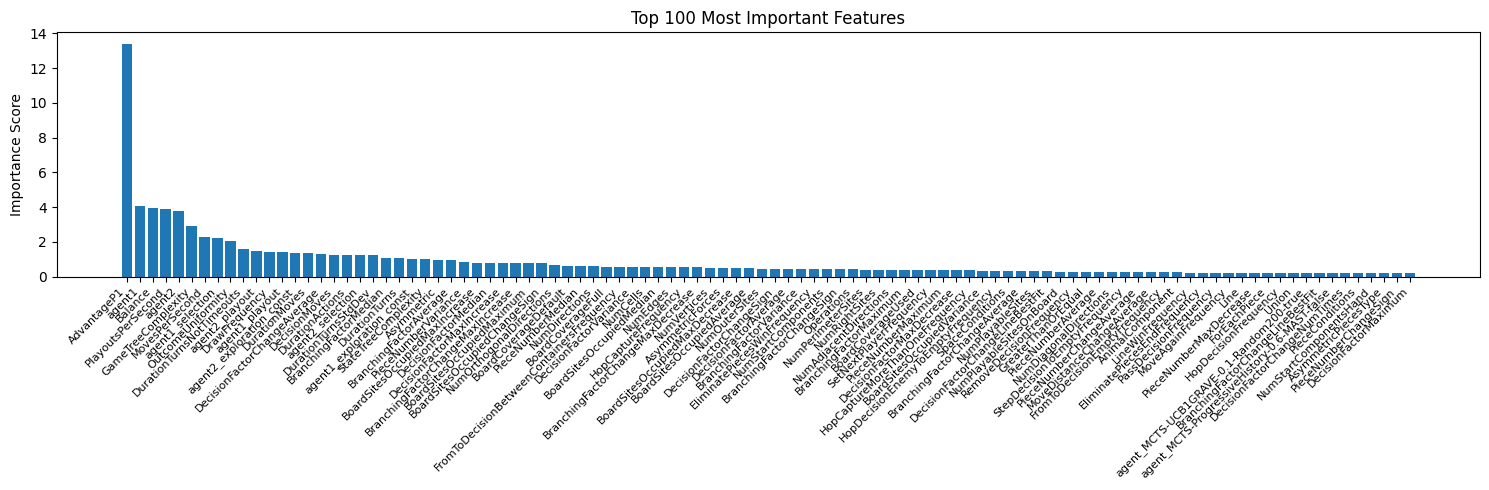

Fold 2 - RMSE: 0.431131218672751
Fold 3


0:	learn: 0.6027420	test: 0.5980128	best: 0.5980128 (0)	total: 89.8ms	remaining: 4m 29s


50:	learn: 0.3899509	test: 0.4663451	best: 0.4663451 (50)	total: 5.07s	remaining: 4m 53s


100:	learn: 0.3516096	test: 0.4508531	best: 0.4508531 (100)	total: 10.4s	remaining: 4m 57s


150:	learn: 0.3288761	test: 0.4426264	best: 0.4426264 (150)	total: 15.5s	remaining: 4m 53s


200:	learn: 0.3124148	test: 0.4381519	best: 0.4379658 (198)	total: 20.8s	remaining: 4m 49s


250:	learn: 0.3000333	test: 0.4364988	best: 0.4364988 (250)	total: 25.8s	remaining: 4m 42s


300:	learn: 0.2899649	test: 0.4349304	best: 0.4349304 (300)	total: 31s	remaining: 4m 38s


350:	learn: 0.2819641	test: 0.4335562	best: 0.4335562 (350)	total: 36.3s	remaining: 4m 33s


400:	learn: 0.2752444	test: 0.4323334	best: 0.4323334 (400)	total: 41.5s	remaining: 4m 28s


450:	learn: 0.2691861	test: 0.4313163	best: 0.4313163 (450)	total: 46.6s	remaining: 4m 23s


500:	learn: 0.2628259	test: 0.4307970	best: 0.4307805 (499)	total: 51.8s	remaining: 4m 18s


550:	learn: 0.2576449	test: 0.4302439	best: 0.4302439 (550)	total: 56.9s	remaining: 4m 12s


600:	learn: 0.2534526	test: 0.4295965	best: 0.4295847 (595)	total: 1m 2s	remaining: 4m 7s


650:	learn: 0.2494163	test: 0.4293892	best: 0.4293607 (646)	total: 1m 7s	remaining: 4m 2s


700:	learn: 0.2456430	test: 0.4289105	best: 0.4288576 (697)	total: 1m 12s	remaining: 3m 58s


750:	learn: 0.2423020	test: 0.4284697	best: 0.4284697 (750)	total: 1m 17s	remaining: 3m 53s


800:	learn: 0.2388252	test: 0.4282646	best: 0.4282466 (798)	total: 1m 22s	remaining: 3m 47s


850:	learn: 0.2356089	test: 0.4280723	best: 0.4280215 (847)	total: 1m 28s	remaining: 3m 42s


900:	learn: 0.2325086	test: 0.4279724	best: 0.4279662 (898)	total: 1m 33s	remaining: 3m 37s


950:	learn: 0.2294467	test: 0.4275945	best: 0.4275494 (948)	total: 1m 38s	remaining: 3m 32s


1000:	learn: 0.2266691	test: 0.4275115	best: 0.4274522 (991)	total: 1m 43s	remaining: 3m 27s


1050:	learn: 0.2241021	test: 0.4272999	best: 0.4272391 (1041)	total: 1m 49s	remaining: 3m 22s


1100:	learn: 0.2216773	test: 0.4272522	best: 0.4272343 (1095)	total: 1m 54s	remaining: 3m 17s


1150:	learn: 0.2194628	test: 0.4271944	best: 0.4271831 (1138)	total: 1m 59s	remaining: 3m 12s


1200:	learn: 0.2171973	test: 0.4269772	best: 0.4269772 (1200)	total: 2m 4s	remaining: 3m 7s


1250:	learn: 0.2147718	test: 0.4269272	best: 0.4269272 (1250)	total: 2m 10s	remaining: 3m 1s


1300:	learn: 0.2126674	test: 0.4269033	best: 0.4268799 (1287)	total: 2m 15s	remaining: 2m 56s


1350:	learn: 0.2106673	test: 0.4266424	best: 0.4266378 (1344)	total: 2m 20s	remaining: 2m 51s


1400:	learn: 0.2086694	test: 0.4265329	best: 0.4265181 (1399)	total: 2m 25s	remaining: 2m 46s


1450:	learn: 0.2069497	test: 0.4266088	best: 0.4265181 (1399)	total: 2m 30s	remaining: 2m 40s


1500:	learn: 0.2051868	test: 0.4265160	best: 0.4265057 (1470)	total: 2m 35s	remaining: 2m 35s


1550:	learn: 0.2035021	test: 0.4263533	best: 0.4263533 (1550)	total: 2m 41s	remaining: 2m 30s


1600:	learn: 0.2015605	test: 0.4263363	best: 0.4263089 (1592)	total: 2m 46s	remaining: 2m 25s


1650:	learn: 0.1999401	test: 0.4262213	best: 0.4262127 (1648)	total: 2m 51s	remaining: 2m 20s


1700:	learn: 0.1981618	test: 0.4261412	best: 0.4260657 (1683)	total: 2m 56s	remaining: 2m 14s


1750:	learn: 0.1967085	test: 0.4260772	best: 0.4260657 (1683)	total: 3m 1s	remaining: 2m 9s


1800:	learn: 0.1951742	test: 0.4260730	best: 0.4260558 (1790)	total: 3m 6s	remaining: 2m 4s


1850:	learn: 0.1937393	test: 0.4260605	best: 0.4260240 (1841)	total: 3m 12s	remaining: 1m 59s


1900:	learn: 0.1923017	test: 0.4260538	best: 0.4259967 (1874)	total: 3m 17s	remaining: 1m 54s


1950:	learn: 0.1908726	test: 0.4260202	best: 0.4259803 (1942)	total: 3m 22s	remaining: 1m 48s


2000:	learn: 0.1895661	test: 0.4260100	best: 0.4259803 (1942)	total: 3m 27s	remaining: 1m 43s


2050:	learn: 0.1881478	test: 0.4259881	best: 0.4259803 (1942)	total: 3m 33s	remaining: 1m 38s


2100:	learn: 0.1867765	test: 0.4259257	best: 0.4259257 (2100)	total: 3m 38s	remaining: 1m 33s


2150:	learn: 0.1854144	test: 0.4259283	best: 0.4259073 (2140)	total: 3m 43s	remaining: 1m 28s


2200:	learn: 0.1840926	test: 0.4259612	best: 0.4259073 (2140)	total: 3m 48s	remaining: 1m 23s


2250:	learn: 0.1827341	test: 0.4259072	best: 0.4258940 (2243)	total: 3m 53s	remaining: 1m 17s


2300:	learn: 0.1814593	test: 0.4258873	best: 0.4258814 (2253)	total: 3m 59s	remaining: 1m 12s


2350:	learn: 0.1800978	test: 0.4257825	best: 0.4257781 (2348)	total: 4m 4s	remaining: 1m 7s


2400:	learn: 0.1787992	test: 0.4257836	best: 0.4257544 (2377)	total: 4m 9s	remaining: 1m 2s


2450:	learn: 0.1775505	test: 0.4257035	best: 0.4257035 (2450)	total: 4m 14s	remaining: 57s


2500:	learn: 0.1763134	test: 0.4257101	best: 0.4256808 (2468)	total: 4m 19s	remaining: 51.8s


2550:	learn: 0.1750321	test: 0.4257203	best: 0.4256808 (2468)	total: 4m 24s	remaining: 46.6s


2600:	learn: 0.1738193	test: 0.4257317	best: 0.4256808 (2468)	total: 4m 30s	remaining: 41.4s


2650:	learn: 0.1727118	test: 0.4256855	best: 0.4256808 (2468)	total: 4m 35s	remaining: 36.2s


2700:	learn: 0.1715422	test: 0.4256966	best: 0.4256535 (2678)	total: 4m 40s	remaining: 31s


2750:	learn: 0.1703958	test: 0.4256118	best: 0.4256086 (2749)	total: 4m 45s	remaining: 25.8s


2800:	learn: 0.1692759	test: 0.4256272	best: 0.4256086 (2749)	total: 4m 50s	remaining: 20.7s


2850:	learn: 0.1682296	test: 0.4256664	best: 0.4256086 (2749)	total: 4m 55s	remaining: 15.5s


2900:	learn: 0.1671229	test: 0.4256646	best: 0.4256086 (2749)	total: 5m 1s	remaining: 10.3s


2950:	learn: 0.1660827	test: 0.4256542	best: 0.4256086 (2749)	total: 5m 6s	remaining: 5.09s


2999:	learn: 0.1649674	test: 0.4256091	best: 0.4256054 (2977)	total: 5m 11s	remaining: 0us

bestTest = 0.4256054415
bestIteration = 2977

Shrink model to first 2978 iterations.


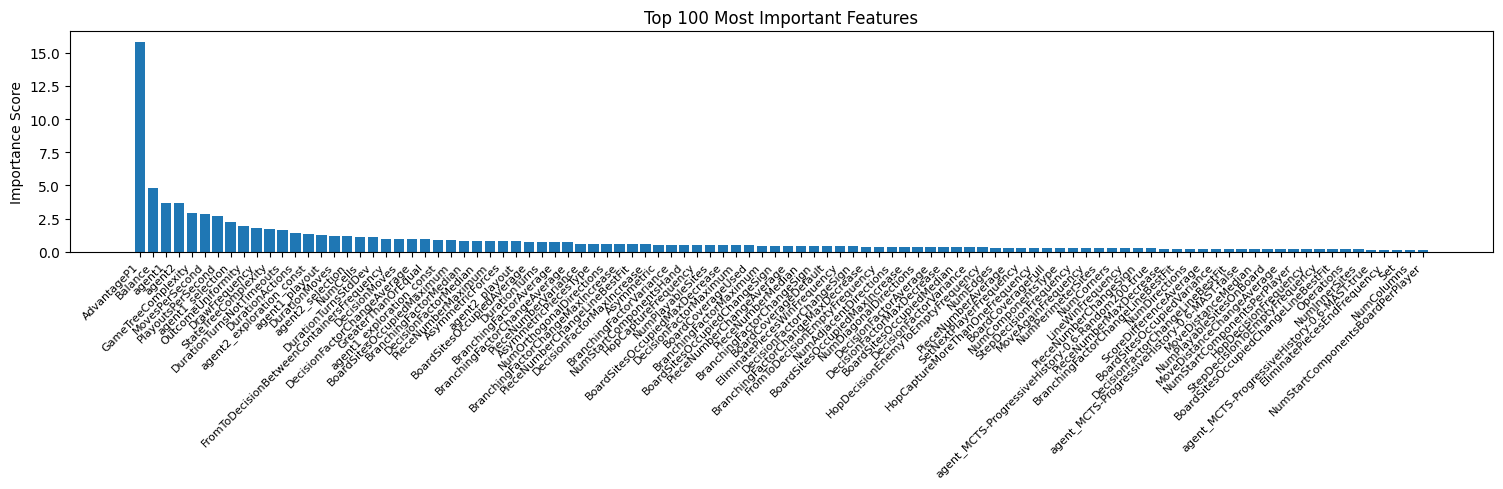

Fold 3 - RMSE: 0.4247324537395854
Fold 4


0:	learn: 0.6025575	test: 0.5918161	best: 0.5918161 (0)	total: 92.5ms	remaining: 4m 37s


50:	learn: 0.3877598	test: 0.4820522	best: 0.4820522 (50)	total: 4.82s	remaining: 4m 38s


100:	learn: 0.3476623	test: 0.4603269	best: 0.4603269 (100)	total: 9.9s	remaining: 4m 44s


150:	learn: 0.3247958	test: 0.4514050	best: 0.4514050 (150)	total: 15s	remaining: 4m 42s


200:	learn: 0.3072072	test: 0.4457484	best: 0.4457484 (200)	total: 20s	remaining: 4m 38s


250:	learn: 0.2952580	test: 0.4438698	best: 0.4438607 (249)	total: 25s	remaining: 4m 33s


300:	learn: 0.2859438	test: 0.4431007	best: 0.4429153 (295)	total: 30.1s	remaining: 4m 29s


350:	learn: 0.2775386	test: 0.4416525	best: 0.4416525 (350)	total: 35.2s	remaining: 4m 25s


400:	learn: 0.2704877	test: 0.4409261	best: 0.4409248 (384)	total: 40.3s	remaining: 4m 21s


450:	learn: 0.2643425	test: 0.4403011	best: 0.4403011 (450)	total: 45.4s	remaining: 4m 16s


500:	learn: 0.2587889	test: 0.4392626	best: 0.4392072 (498)	total: 50.5s	remaining: 4m 11s


550:	learn: 0.2534747	test: 0.4388445	best: 0.4388387 (531)	total: 55.6s	remaining: 4m 7s


600:	learn: 0.2493607	test: 0.4383599	best: 0.4383442 (599)	total: 1m	remaining: 4m 2s


650:	learn: 0.2453019	test: 0.4379697	best: 0.4379697 (650)	total: 1m 5s	remaining: 3m 57s


700:	learn: 0.2417737	test: 0.4378049	best: 0.4377040 (698)	total: 1m 11s	remaining: 3m 53s


750:	learn: 0.2385602	test: 0.4373731	best: 0.4373432 (744)	total: 1m 16s	remaining: 3m 48s


800:	learn: 0.2350317	test: 0.4373368	best: 0.4372221 (765)	total: 1m 21s	remaining: 3m 42s


850:	learn: 0.2318494	test: 0.4370480	best: 0.4370480 (850)	total: 1m 26s	remaining: 3m 37s


900:	learn: 0.2288898	test: 0.4368391	best: 0.4368267 (889)	total: 1m 31s	remaining: 3m 32s


950:	learn: 0.2262882	test: 0.4365225	best: 0.4365225 (950)	total: 1m 36s	remaining: 3m 27s


1000:	learn: 0.2237652	test: 0.4364403	best: 0.4364383 (999)	total: 1m 41s	remaining: 3m 22s


1050:	learn: 0.2213439	test: 0.4361615	best: 0.4361615 (1050)	total: 1m 46s	remaining: 3m 17s


1100:	learn: 0.2190977	test: 0.4359299	best: 0.4359294 (1099)	total: 1m 51s	remaining: 3m 12s


1150:	learn: 0.2168772	test: 0.4357740	best: 0.4357680 (1149)	total: 1m 56s	remaining: 3m 7s


1200:	learn: 0.2145451	test: 0.4356517	best: 0.4356450 (1184)	total: 2m 2s	remaining: 3m 2s


1250:	learn: 0.2123479	test: 0.4353282	best: 0.4353104 (1238)	total: 2m 7s	remaining: 2m 57s


1300:	learn: 0.2100767	test: 0.4351297	best: 0.4351294 (1299)	total: 2m 12s	remaining: 2m 52s


1350:	learn: 0.2081725	test: 0.4349924	best: 0.4349924 (1350)	total: 2m 17s	remaining: 2m 47s


1400:	learn: 0.2062461	test: 0.4348387	best: 0.4348380 (1399)	total: 2m 22s	remaining: 2m 42s


1450:	learn: 0.2043028	test: 0.4347193	best: 0.4347105 (1446)	total: 2m 27s	remaining: 2m 37s


1500:	learn: 0.2025540	test: 0.4347227	best: 0.4346966 (1459)	total: 2m 32s	remaining: 2m 32s


1550:	learn: 0.2008839	test: 0.4346263	best: 0.4346225 (1547)	total: 2m 37s	remaining: 2m 27s


1600:	learn: 0.1991829	test: 0.4345949	best: 0.4345787 (1562)	total: 2m 42s	remaining: 2m 22s


1650:	learn: 0.1976711	test: 0.4345692	best: 0.4345612 (1646)	total: 2m 47s	remaining: 2m 17s


1700:	learn: 0.1962256	test: 0.4344744	best: 0.4344744 (1700)	total: 2m 53s	remaining: 2m 12s


1750:	learn: 0.1946859	test: 0.4344042	best: 0.4343953 (1747)	total: 2m 58s	remaining: 2m 7s


1800:	learn: 0.1930532	test: 0.4342283	best: 0.4342223 (1797)	total: 3m 3s	remaining: 2m 2s


1850:	learn: 0.1915810	test: 0.4341903	best: 0.4341902 (1847)	total: 3m 8s	remaining: 1m 56s


1900:	learn: 0.1901431	test: 0.4340994	best: 0.4340955 (1890)	total: 3m 13s	remaining: 1m 51s


1950:	learn: 0.1887589	test: 0.4340740	best: 0.4340482 (1931)	total: 3m 18s	remaining: 1m 46s


2000:	learn: 0.1873127	test: 0.4341025	best: 0.4340420 (1959)	total: 3m 23s	remaining: 1m 41s


2050:	learn: 0.1858399	test: 0.4341154	best: 0.4340420 (1959)	total: 3m 28s	remaining: 1m 36s


2100:	learn: 0.1843292	test: 0.4340505	best: 0.4340420 (1959)	total: 3m 33s	remaining: 1m 31s


2150:	learn: 0.1829576	test: 0.4339698	best: 0.4339698 (2150)	total: 3m 39s	remaining: 1m 26s


2200:	learn: 0.1815092	test: 0.4339764	best: 0.4339698 (2150)	total: 3m 44s	remaining: 1m 21s


2250:	learn: 0.1802620	test: 0.4339505	best: 0.4339373 (2241)	total: 3m 49s	remaining: 1m 16s


2300:	learn: 0.1789554	test: 0.4339495	best: 0.4339271 (2273)	total: 3m 54s	remaining: 1m 11s


2350:	learn: 0.1777259	test: 0.4339606	best: 0.4338953 (2314)	total: 3m 59s	remaining: 1m 6s


2400:	learn: 0.1765102	test: 0.4339651	best: 0.4338953 (2314)	total: 4m 4s	remaining: 1m


2450:	learn: 0.1751062	test: 0.4339788	best: 0.4338953 (2314)	total: 4m 9s	remaining: 55.9s


2500:	learn: 0.1739546	test: 0.4340317	best: 0.4338953 (2314)	total: 4m 14s	remaining: 50.8s


2550:	learn: 0.1728274	test: 0.4339963	best: 0.4338953 (2314)	total: 4m 19s	remaining: 45.7s


2600:	learn: 0.1717434	test: 0.4340100	best: 0.4338953 (2314)	total: 4m 24s	remaining: 40.6s


2650:	learn: 0.1705403	test: 0.4340096	best: 0.4338953 (2314)	total: 4m 29s	remaining: 35.5s


2700:	learn: 0.1693746	test: 0.4339614	best: 0.4338953 (2314)	total: 4m 34s	remaining: 30.4s


2750:	learn: 0.1682782	test: 0.4339398	best: 0.4338953 (2314)	total: 4m 40s	remaining: 25.3s


2800:	learn: 0.1671586	test: 0.4339321	best: 0.4338953 (2314)	total: 4m 45s	remaining: 20.3s


2850:	learn: 0.1661631	test: 0.4339659	best: 0.4338953 (2314)	total: 4m 50s	remaining: 15.2s


2900:	learn: 0.1650738	test: 0.4339220	best: 0.4338953 (2314)	total: 4m 55s	remaining: 10.1s


2950:	learn: 0.1639215	test: 0.4339511	best: 0.4338953 (2314)	total: 5m	remaining: 4.99s


2999:	learn: 0.1628160	test: 0.4339085	best: 0.4338924 (2985)	total: 5m 5s	remaining: 0us

bestTest = 0.4338924378
bestIteration = 2985

Shrink model to first 2986 iterations.


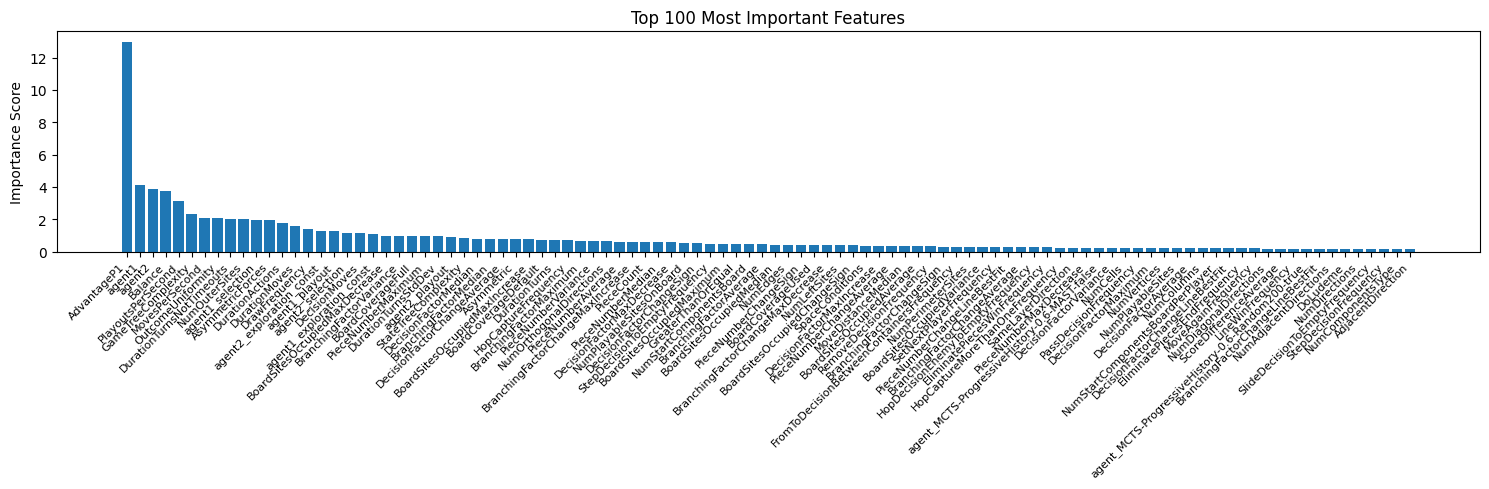

Fold 4 - RMSE: 0.43323941786616527
Fold 5


0:	learn: 0.6171469	test: 0.5441480	best: 0.5441480 (0)	total: 82ms	remaining: 4m 5s


50:	learn: 0.3968302	test: 0.4518238	best: 0.4518238 (50)	total: 4.81s	remaining: 4m 38s


100:	learn: 0.3559065	test: 0.4307097	best: 0.4307097 (100)	total: 9.88s	remaining: 4m 43s


150:	learn: 0.3321658	test: 0.4223882	best: 0.4223882 (150)	total: 14.9s	remaining: 4m 40s


200:	learn: 0.3150510	test: 0.4184141	best: 0.4184141 (200)	total: 19.9s	remaining: 4m 37s


250:	learn: 0.3024415	test: 0.4153683	best: 0.4153683 (250)	total: 24.9s	remaining: 4m 32s


300:	learn: 0.2927670	test: 0.4128453	best: 0.4128453 (300)	total: 29.9s	remaining: 4m 27s


350:	learn: 0.2842977	test: 0.4115879	best: 0.4115459 (344)	total: 34.8s	remaining: 4m 22s


400:	learn: 0.2770262	test: 0.4103301	best: 0.4103301 (400)	total: 39.8s	remaining: 4m 17s


450:	learn: 0.2704951	test: 0.4091960	best: 0.4091841 (446)	total: 44.6s	remaining: 4m 12s


500:	learn: 0.2651498	test: 0.4086479	best: 0.4086014 (496)	total: 49.7s	remaining: 4m 7s


550:	learn: 0.2596601	test: 0.4078430	best: 0.4078360 (543)	total: 54.6s	remaining: 4m 2s


600:	learn: 0.2551327	test: 0.4075841	best: 0.4075458 (596)	total: 59.7s	remaining: 3m 58s


650:	learn: 0.2508481	test: 0.4072710	best: 0.4072710 (650)	total: 1m 4s	remaining: 3m 53s


700:	learn: 0.2469053	test: 0.4070705	best: 0.4070695 (696)	total: 1m 9s	remaining: 3m 48s


750:	learn: 0.2431474	test: 0.4069440	best: 0.4069336 (749)	total: 1m 14s	remaining: 3m 43s


800:	learn: 0.2398735	test: 0.4067413	best: 0.4067368 (792)	total: 1m 19s	remaining: 3m 38s


850:	learn: 0.2366015	test: 0.4064285	best: 0.4064285 (850)	total: 1m 24s	remaining: 3m 34s


900:	learn: 0.2336988	test: 0.4061671	best: 0.4061529 (899)	total: 1m 29s	remaining: 3m 29s


950:	learn: 0.2307877	test: 0.4060931	best: 0.4060798 (927)	total: 1m 34s	remaining: 3m 24s


1000:	learn: 0.2281504	test: 0.4059748	best: 0.4059671 (997)	total: 1m 39s	remaining: 3m 19s


1050:	learn: 0.2256503	test: 0.4059125	best: 0.4059125 (1050)	total: 1m 44s	remaining: 3m 14s


1100:	learn: 0.2232439	test: 0.4056531	best: 0.4056531 (1100)	total: 1m 49s	remaining: 3m 9s


1150:	learn: 0.2211506	test: 0.4056697	best: 0.4056481 (1113)	total: 1m 54s	remaining: 3m 4s


1200:	learn: 0.2187052	test: 0.4057389	best: 0.4056481 (1113)	total: 2m	remaining: 2m 59s


1250:	learn: 0.2164674	test: 0.4057398	best: 0.4056177 (1219)	total: 2m 5s	remaining: 2m 54s


1300:	learn: 0.2142708	test: 0.4056935	best: 0.4056174 (1276)	total: 2m 10s	remaining: 2m 49s


1350:	learn: 0.2120843	test: 0.4055951	best: 0.4055951 (1350)	total: 2m 15s	remaining: 2m 44s


1400:	learn: 0.2101029	test: 0.4056204	best: 0.4055890 (1352)	total: 2m 20s	remaining: 2m 39s


1450:	learn: 0.2082463	test: 0.4056141	best: 0.4055682 (1408)	total: 2m 25s	remaining: 2m 34s


1500:	learn: 0.2062931	test: 0.4057077	best: 0.4055682 (1408)	total: 2m 30s	remaining: 2m 29s


1550:	learn: 0.2042761	test: 0.4057621	best: 0.4055682 (1408)	total: 2m 34s	remaining: 2m 24s


1600:	learn: 0.2026453	test: 0.4057828	best: 0.4055682 (1408)	total: 2m 40s	remaining: 2m 19s


1650:	learn: 0.2007957	test: 0.4056460	best: 0.4055682 (1408)	total: 2m 45s	remaining: 2m 14s


1700:	learn: 0.1991796	test: 0.4055338	best: 0.4055160 (1698)	total: 2m 50s	remaining: 2m 9s


1750:	learn: 0.1975424	test: 0.4055581	best: 0.4055160 (1698)	total: 2m 55s	remaining: 2m 4s


1800:	learn: 0.1957671	test: 0.4054891	best: 0.4054530 (1791)	total: 3m	remaining: 1m 59s


1850:	learn: 0.1941687	test: 0.4054235	best: 0.4054103 (1848)	total: 3m 5s	remaining: 1m 55s


1900:	learn: 0.1925841	test: 0.4053649	best: 0.4053423 (1895)	total: 3m 10s	remaining: 1m 49s


1950:	learn: 0.1911796	test: 0.4051830	best: 0.4051830 (1950)	total: 3m 15s	remaining: 1m 45s


2000:	learn: 0.1897073	test: 0.4051657	best: 0.4051331 (1974)	total: 3m 20s	remaining: 1m 40s


2050:	learn: 0.1881568	test: 0.4051019	best: 0.4050924 (2026)	total: 3m 25s	remaining: 1m 35s


2100:	learn: 0.1867651	test: 0.4050548	best: 0.4050548 (2100)	total: 3m 30s	remaining: 1m 30s


2150:	learn: 0.1854604	test: 0.4051122	best: 0.4050380 (2108)	total: 3m 35s	remaining: 1m 25s


2200:	learn: 0.1841615	test: 0.4051438	best: 0.4050380 (2108)	total: 3m 40s	remaining: 1m 20s


2250:	learn: 0.1827977	test: 0.4051447	best: 0.4050380 (2108)	total: 3m 45s	remaining: 1m 15s


2300:	learn: 0.1816029	test: 0.4051211	best: 0.4050380 (2108)	total: 3m 50s	remaining: 1m 10s


2350:	learn: 0.1801865	test: 0.4051048	best: 0.4050380 (2108)	total: 3m 55s	remaining: 1m 5s


2400:	learn: 0.1789538	test: 0.4050888	best: 0.4050380 (2108)	total: 4m	remaining: 1m


2450:	learn: 0.1776546	test: 0.4050821	best: 0.4050380 (2108)	total: 4m 5s	remaining: 55s


2500:	learn: 0.1763870	test: 0.4051063	best: 0.4050380 (2108)	total: 4m 10s	remaining: 50s


2550:	learn: 0.1752452	test: 0.4051389	best: 0.4050380 (2108)	total: 4m 15s	remaining: 45s


2600:	learn: 0.1740824	test: 0.4051350	best: 0.4050380 (2108)	total: 4m 20s	remaining: 40s


2650:	learn: 0.1729450	test: 0.4050665	best: 0.4050380 (2108)	total: 4m 25s	remaining: 35s


2700:	learn: 0.1716010	test: 0.4050917	best: 0.4050380 (2108)	total: 4m 30s	remaining: 30s


2750:	learn: 0.1703670	test: 0.4050972	best: 0.4050380 (2108)	total: 4m 35s	remaining: 25s


2800:	learn: 0.1691928	test: 0.4051670	best: 0.4050380 (2108)	total: 4m 40s	remaining: 19.9s


2850:	learn: 0.1680467	test: 0.4051608	best: 0.4050380 (2108)	total: 4m 45s	remaining: 14.9s


2900:	learn: 0.1668833	test: 0.4051222	best: 0.4050380 (2108)	total: 4m 50s	remaining: 9.92s


2950:	learn: 0.1658683	test: 0.4052383	best: 0.4050380 (2108)	total: 4m 55s	remaining: 4.91s


2999:	learn: 0.1647985	test: 0.4052271	best: 0.4050380 (2108)	total: 5m	remaining: 0us

bestTest = 0.4050379986
bestIteration = 2108

Shrink model to first 2109 iterations.


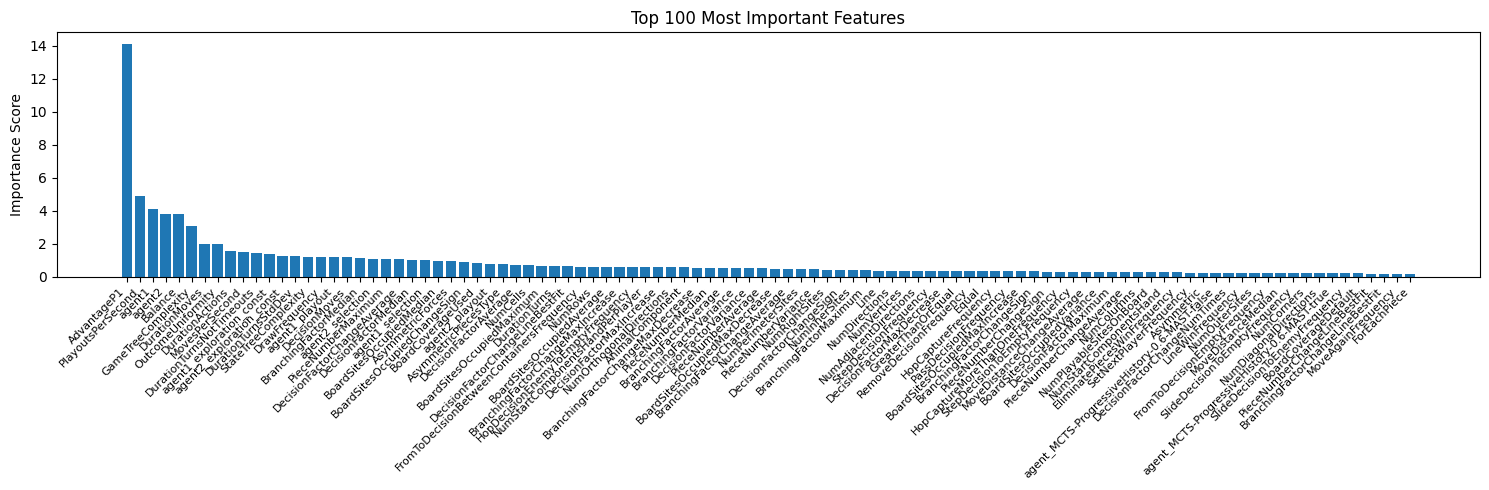

Fold 5 - RMSE: 0.40454719825053514
List of oof scores: [0.42107816773911977, 0.431131218672751, 0.4247324537395854, 0.43323941786616527, 0.40454719825053514]
Average oof score: 0.4229456912536313


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_catboost_{fs_type}_cv1.parquet', index=False)

# save feature importance
# importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

Fold 1


0:	learn: 0.6187574	test: 0.5282067	best: 0.5282067 (0)	total: 85.7ms	remaining: 4m 17s


50:	learn: 0.3909325	test: 0.4483073	best: 0.4483073 (50)	total: 4.78s	remaining: 4m 36s


100:	learn: 0.3500755	test: 0.4326630	best: 0.4326630 (100)	total: 9.76s	remaining: 4m 40s


150:	learn: 0.3253456	test: 0.4274007	best: 0.4273675 (149)	total: 14.7s	remaining: 4m 36s


200:	learn: 0.3096378	test: 0.4231932	best: 0.4231932 (200)	total: 19.6s	remaining: 4m 33s


250:	learn: 0.2974418	test: 0.4214945	best: 0.4214945 (250)	total: 24.6s	remaining: 4m 29s


300:	learn: 0.2872369	test: 0.4197452	best: 0.4197390 (299)	total: 29.5s	remaining: 4m 24s


350:	learn: 0.2782007	test: 0.4181941	best: 0.4180359 (346)	total: 34.5s	remaining: 4m 20s


400:	learn: 0.2710079	test: 0.4172819	best: 0.4172819 (400)	total: 39.5s	remaining: 4m 16s


450:	learn: 0.2649495	test: 0.4165413	best: 0.4165413 (450)	total: 44.7s	remaining: 4m 12s


500:	learn: 0.2591547	test: 0.4156854	best: 0.4156357 (494)	total: 49.7s	remaining: 4m 7s


550:	learn: 0.2542532	test: 0.4153437	best: 0.4152041 (533)	total: 54.7s	remaining: 4m 3s


600:	learn: 0.2494277	test: 0.4143555	best: 0.4143555 (600)	total: 59.8s	remaining: 3m 58s


650:	learn: 0.2450991	test: 0.4139082	best: 0.4138387 (642)	total: 1m 4s	remaining: 3m 53s


700:	learn: 0.2413860	test: 0.4135975	best: 0.4135809 (699)	total: 1m 9s	remaining: 3m 48s


750:	learn: 0.2375382	test: 0.4132937	best: 0.4132892 (749)	total: 1m 14s	remaining: 3m 43s


800:	learn: 0.2339537	test: 0.4129891	best: 0.4129778 (799)	total: 1m 19s	remaining: 3m 38s


850:	learn: 0.2307144	test: 0.4128238	best: 0.4128238 (850)	total: 1m 24s	remaining: 3m 34s


900:	learn: 0.2277931	test: 0.4126413	best: 0.4126413 (900)	total: 1m 29s	remaining: 3m 29s


950:	learn: 0.2247874	test: 0.4123115	best: 0.4122763 (943)	total: 1m 34s	remaining: 3m 24s


1000:	learn: 0.2221699	test: 0.4121570	best: 0.4121218 (985)	total: 1m 39s	remaining: 3m 19s


1050:	learn: 0.2195655	test: 0.4120348	best: 0.4120348 (1050)	total: 1m 44s	remaining: 3m 14s


1100:	learn: 0.2171032	test: 0.4120056	best: 0.4119529 (1094)	total: 1m 49s	remaining: 3m 9s


1150:	learn: 0.2149545	test: 0.4120610	best: 0.4119529 (1094)	total: 1m 55s	remaining: 3m 4s


1200:	learn: 0.2128399	test: 0.4120224	best: 0.4119529 (1094)	total: 2m	remaining: 2m 59s


1250:	learn: 0.2107547	test: 0.4120943	best: 0.4119529 (1094)	total: 2m 5s	remaining: 2m 54s


1300:	learn: 0.2087305	test: 0.4120559	best: 0.4119529 (1094)	total: 2m 10s	remaining: 2m 50s


1350:	learn: 0.2066622	test: 0.4120716	best: 0.4119529 (1094)	total: 2m 15s	remaining: 2m 45s


1400:	learn: 0.2048089	test: 0.4119984	best: 0.4119529 (1094)	total: 2m 20s	remaining: 2m 40s


1450:	learn: 0.2028692	test: 0.4119580	best: 0.4119529 (1094)	total: 2m 25s	remaining: 2m 35s


1500:	learn: 0.2013512	test: 0.4119623	best: 0.4119335 (1462)	total: 2m 30s	remaining: 2m 30s


1550:	learn: 0.1995801	test: 0.4120408	best: 0.4119335 (1462)	total: 2m 35s	remaining: 2m 25s


1600:	learn: 0.1977471	test: 0.4119083	best: 0.4118964 (1585)	total: 2m 40s	remaining: 2m 20s


1650:	learn: 0.1960984	test: 0.4118794	best: 0.4118615 (1634)	total: 2m 45s	remaining: 2m 15s


1700:	learn: 0.1942742	test: 0.4118331	best: 0.4118207 (1697)	total: 2m 50s	remaining: 2m 10s


1750:	learn: 0.1927084	test: 0.4117645	best: 0.4117625 (1748)	total: 2m 55s	remaining: 2m 5s


1800:	learn: 0.1910305	test: 0.4117738	best: 0.4117158 (1752)	total: 3m 1s	remaining: 2m


1850:	learn: 0.1896909	test: 0.4117223	best: 0.4117158 (1752)	total: 3m 6s	remaining: 1m 55s


1900:	learn: 0.1882253	test: 0.4116764	best: 0.4116764 (1900)	total: 3m 11s	remaining: 1m 50s


1950:	learn: 0.1867641	test: 0.4116834	best: 0.4116514 (1939)	total: 3m 16s	remaining: 1m 45s


2000:	learn: 0.1853743	test: 0.4116578	best: 0.4116303 (1995)	total: 3m 21s	remaining: 1m 40s


2050:	learn: 0.1838438	test: 0.4116115	best: 0.4116070 (2042)	total: 3m 26s	remaining: 1m 35s


2100:	learn: 0.1824605	test: 0.4115848	best: 0.4115824 (2066)	total: 3m 31s	remaining: 1m 30s


2150:	learn: 0.1811166	test: 0.4115982	best: 0.4115634 (2130)	total: 3m 36s	remaining: 1m 25s


2200:	learn: 0.1798516	test: 0.4115992	best: 0.4115634 (2130)	total: 3m 41s	remaining: 1m 20s


2250:	learn: 0.1785649	test: 0.4115569	best: 0.4115357 (2220)	total: 3m 46s	remaining: 1m 15s


2300:	learn: 0.1772281	test: 0.4114802	best: 0.4114780 (2297)	total: 3m 51s	remaining: 1m 10s


2350:	learn: 0.1759944	test: 0.4114758	best: 0.4114514 (2345)	total: 3m 56s	remaining: 1m 5s


2400:	learn: 0.1747679	test: 0.4115995	best: 0.4114514 (2345)	total: 4m 1s	remaining: 1m


2450:	learn: 0.1734946	test: 0.4115611	best: 0.4114514 (2345)	total: 4m 6s	remaining: 55.2s


2500:	learn: 0.1722946	test: 0.4115001	best: 0.4114514 (2345)	total: 4m 11s	remaining: 50.2s


2550:	learn: 0.1711017	test: 0.4114604	best: 0.4114514 (2345)	total: 4m 16s	remaining: 45.2s


2600:	learn: 0.1699480	test: 0.4115165	best: 0.4114514 (2345)	total: 4m 21s	remaining: 40.1s


2650:	learn: 0.1687981	test: 0.4115367	best: 0.4114514 (2345)	total: 4m 26s	remaining: 35.1s


2700:	learn: 0.1675550	test: 0.4114466	best: 0.4114466 (2700)	total: 4m 31s	remaining: 30.1s


2750:	learn: 0.1663655	test: 0.4114599	best: 0.4114406 (2706)	total: 4m 37s	remaining: 25.1s


2800:	learn: 0.1651961	test: 0.4114528	best: 0.4114321 (2773)	total: 4m 42s	remaining: 20s


2850:	learn: 0.1639636	test: 0.4114211	best: 0.4114101 (2848)	total: 4m 47s	remaining: 15s


2900:	learn: 0.1628500	test: 0.4114278	best: 0.4114046 (2860)	total: 4m 52s	remaining: 9.97s


2950:	learn: 0.1618336	test: 0.4114472	best: 0.4114046 (2860)	total: 4m 57s	remaining: 4.93s


2999:	learn: 0.1607756	test: 0.4114585	best: 0.4114046 (2860)	total: 5m 2s	remaining: 0us

bestTest = 0.411404587
bestIteration = 2860

Shrink model to first 2861 iterations.


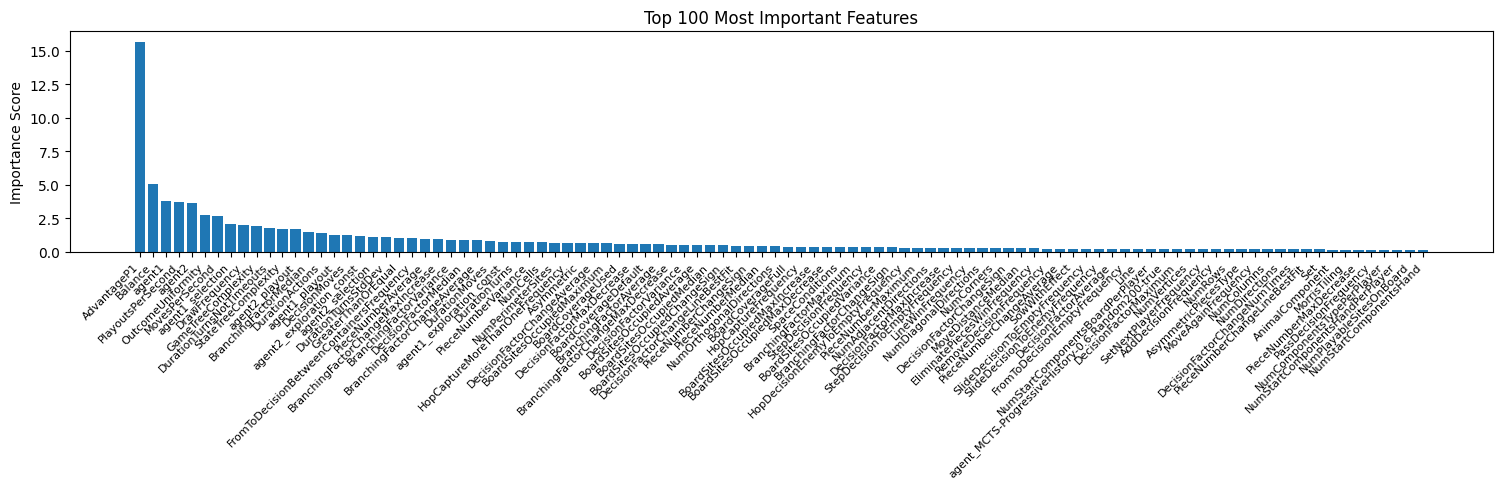

Fold 1 - RMSE: 0.4110637674257878
Fold 2


0:	learn: 0.6142912	test: 0.5383561	best: 0.5383561 (0)	total: 91.8ms	remaining: 4m 35s


50:	learn: 0.3906639	test: 0.4279271	best: 0.4279271 (50)	total: 4.95s	remaining: 4m 46s


100:	learn: 0.3489406	test: 0.4159341	best: 0.4159341 (100)	total: 10s	remaining: 4m 48s


150:	learn: 0.3248747	test: 0.4091636	best: 0.4091636 (150)	total: 15.1s	remaining: 4m 45s


200:	learn: 0.3081561	test: 0.4063614	best: 0.4063614 (200)	total: 20.2s	remaining: 4m 41s


250:	learn: 0.2959019	test: 0.4044906	best: 0.4044906 (250)	total: 25.4s	remaining: 4m 37s


300:	learn: 0.2855811	test: 0.4034231	best: 0.4034231 (300)	total: 30.5s	remaining: 4m 33s


350:	learn: 0.2771190	test: 0.4026530	best: 0.4025369 (340)	total: 35.5s	remaining: 4m 27s


400:	learn: 0.2701770	test: 0.4023028	best: 0.4021443 (368)	total: 40.6s	remaining: 4m 23s


450:	learn: 0.2642355	test: 0.4020225	best: 0.4020225 (450)	total: 45.7s	remaining: 4m 18s


500:	learn: 0.2592271	test: 0.4014733	best: 0.4014733 (500)	total: 50.9s	remaining: 4m 13s


550:	learn: 0.2537504	test: 0.4013940	best: 0.4011670 (534)	total: 55.9s	remaining: 4m 8s


600:	learn: 0.2492999	test: 0.4012582	best: 0.4011555 (589)	total: 1m	remaining: 4m 3s


650:	learn: 0.2451186	test: 0.4012056	best: 0.4010760 (635)	total: 1m 6s	remaining: 3m 58s


700:	learn: 0.2412061	test: 0.4011180	best: 0.4010385 (688)	total: 1m 11s	remaining: 3m 53s


750:	learn: 0.2378048	test: 0.4012075	best: 0.4010385 (688)	total: 1m 16s	remaining: 3m 48s


800:	learn: 0.2343380	test: 0.4011008	best: 0.4010385 (688)	total: 1m 21s	remaining: 3m 43s


850:	learn: 0.2315879	test: 0.4009964	best: 0.4009877 (848)	total: 1m 26s	remaining: 3m 38s


900:	learn: 0.2287883	test: 0.4008244	best: 0.4007890 (898)	total: 1m 31s	remaining: 3m 34s


950:	learn: 0.2258718	test: 0.4008740	best: 0.4007690 (919)	total: 1m 36s	remaining: 3m 28s


1000:	learn: 0.2231247	test: 0.4007503	best: 0.4007414 (998)	total: 1m 42s	remaining: 3m 23s


1050:	learn: 0.2205604	test: 0.4008080	best: 0.4006855 (1014)	total: 1m 47s	remaining: 3m 18s


1100:	learn: 0.2182326	test: 0.4007424	best: 0.4006855 (1014)	total: 1m 52s	remaining: 3m 13s


1150:	learn: 0.2158589	test: 0.4006445	best: 0.4006436 (1112)	total: 1m 57s	remaining: 3m 8s


1200:	learn: 0.2136779	test: 0.4005267	best: 0.4004915 (1191)	total: 2m 2s	remaining: 3m 3s


1250:	learn: 0.2115230	test: 0.4005808	best: 0.4004752 (1221)	total: 2m 7s	remaining: 2m 58s


1300:	learn: 0.2094783	test: 0.4004532	best: 0.4004532 (1300)	total: 2m 12s	remaining: 2m 53s


1350:	learn: 0.2075249	test: 0.4005700	best: 0.4004532 (1300)	total: 2m 18s	remaining: 2m 48s


1400:	learn: 0.2055257	test: 0.4006057	best: 0.4004532 (1300)	total: 2m 23s	remaining: 2m 43s


1450:	learn: 0.2036558	test: 0.4005964	best: 0.4004532 (1300)	total: 2m 28s	remaining: 2m 38s


1500:	learn: 0.2018713	test: 0.4005802	best: 0.4004532 (1300)	total: 2m 33s	remaining: 2m 33s


1550:	learn: 0.2000599	test: 0.4005506	best: 0.4004532 (1300)	total: 2m 38s	remaining: 2m 28s


1600:	learn: 0.1982464	test: 0.4007085	best: 0.4004532 (1300)	total: 2m 43s	remaining: 2m 22s


1650:	learn: 0.1965136	test: 0.4007352	best: 0.4004532 (1300)	total: 2m 48s	remaining: 2m 17s


1700:	learn: 0.1948457	test: 0.4006833	best: 0.4004532 (1300)	total: 2m 53s	remaining: 2m 12s


1750:	learn: 0.1933226	test: 0.4006636	best: 0.4004532 (1300)	total: 2m 58s	remaining: 2m 7s


1800:	learn: 0.1918582	test: 0.4006891	best: 0.4004532 (1300)	total: 3m 4s	remaining: 2m 2s


1850:	learn: 0.1902211	test: 0.4007471	best: 0.4004532 (1300)	total: 3m 9s	remaining: 1m 57s


1900:	learn: 0.1887520	test: 0.4008338	best: 0.4004532 (1300)	total: 3m 14s	remaining: 1m 52s


1950:	learn: 0.1873147	test: 0.4008777	best: 0.4004532 (1300)	total: 3m 19s	remaining: 1m 47s


2000:	learn: 0.1859839	test: 0.4008423	best: 0.4004532 (1300)	total: 3m 24s	remaining: 1m 42s


2050:	learn: 0.1845532	test: 0.4009204	best: 0.4004532 (1300)	total: 3m 29s	remaining: 1m 37s


2100:	learn: 0.1831060	test: 0.4009153	best: 0.4004532 (1300)	total: 3m 34s	remaining: 1m 31s


2150:	learn: 0.1818746	test: 0.4009036	best: 0.4004532 (1300)	total: 3m 40s	remaining: 1m 26s


2200:	learn: 0.1807243	test: 0.4008568	best: 0.4004532 (1300)	total: 3m 45s	remaining: 1m 21s


2250:	learn: 0.1794697	test: 0.4008762	best: 0.4004532 (1300)	total: 3m 50s	remaining: 1m 16s


2300:	learn: 0.1782145	test: 0.4009691	best: 0.4004532 (1300)	total: 3m 55s	remaining: 1m 11s


2350:	learn: 0.1769652	test: 0.4009747	best: 0.4004532 (1300)	total: 4m 1s	remaining: 1m 6s


2400:	learn: 0.1756320	test: 0.4009486	best: 0.4004532 (1300)	total: 4m 6s	remaining: 1m 1s


2450:	learn: 0.1745360	test: 0.4009456	best: 0.4004532 (1300)	total: 4m 11s	remaining: 56.3s


2500:	learn: 0.1732840	test: 0.4010101	best: 0.4004532 (1300)	total: 4m 16s	remaining: 51.2s


2550:	learn: 0.1720160	test: 0.4010679	best: 0.4004532 (1300)	total: 4m 21s	remaining: 46s


2600:	learn: 0.1708791	test: 0.4011354	best: 0.4004532 (1300)	total: 4m 26s	remaining: 40.9s


2650:	learn: 0.1697110	test: 0.4011274	best: 0.4004532 (1300)	total: 4m 31s	remaining: 35.8s


2700:	learn: 0.1685432	test: 0.4011173	best: 0.4004532 (1300)	total: 4m 37s	remaining: 30.7s


2750:	learn: 0.1674939	test: 0.4011522	best: 0.4004532 (1300)	total: 4m 42s	remaining: 25.5s


2800:	learn: 0.1663331	test: 0.4011871	best: 0.4004532 (1300)	total: 4m 47s	remaining: 20.4s


2850:	learn: 0.1652709	test: 0.4012111	best: 0.4004532 (1300)	total: 4m 52s	remaining: 15.3s


2900:	learn: 0.1642323	test: 0.4012303	best: 0.4004532 (1300)	total: 4m 57s	remaining: 10.2s


2950:	learn: 0.1631771	test: 0.4013187	best: 0.4004532 (1300)	total: 5m 2s	remaining: 5.02s


2999:	learn: 0.1620137	test: 0.4013051	best: 0.4004532 (1300)	total: 5m 7s	remaining: 0us

bestTest = 0.4004532111
bestIteration = 1300

Shrink model to first 1301 iterations.


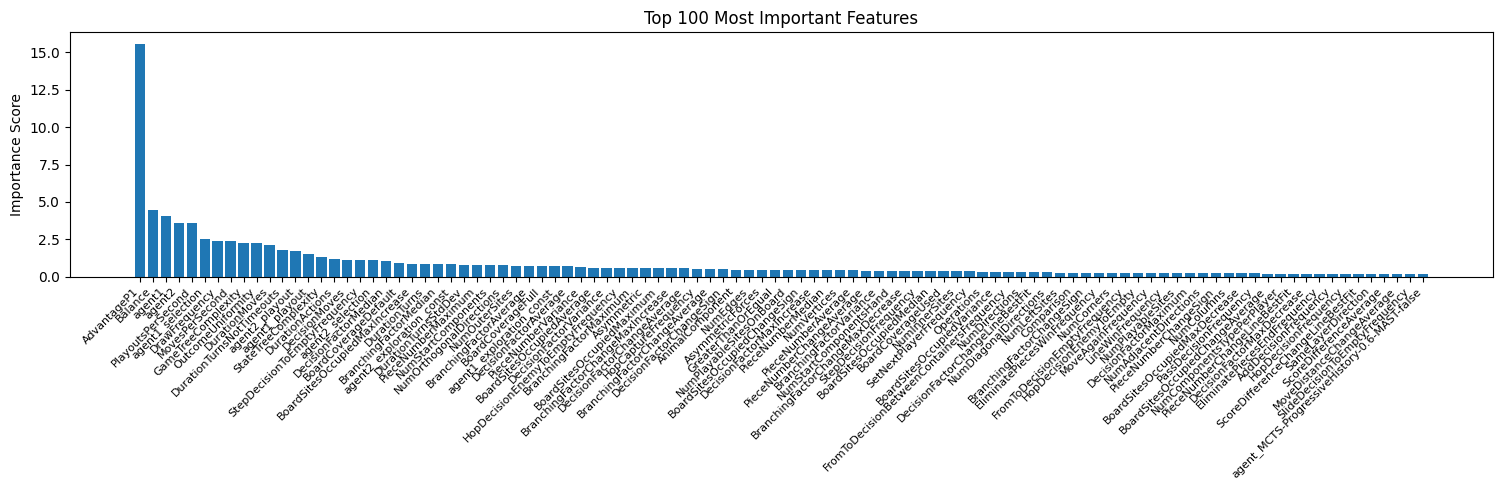

Fold 2 - RMSE: 0.3999019902403095
Fold 3


0:	learn: 0.6014638	test: 0.6082623	best: 0.6082623 (0)	total: 92.8ms	remaining: 4m 38s


50:	learn: 0.3832033	test: 0.4784337	best: 0.4784337 (50)	total: 4.99s	remaining: 4m 48s


100:	learn: 0.3441145	test: 0.4572136	best: 0.4572136 (100)	total: 10.1s	remaining: 4m 51s


150:	learn: 0.3198245	test: 0.4478109	best: 0.4478109 (150)	total: 15.2s	remaining: 4m 46s


200:	learn: 0.3040859	test: 0.4431613	best: 0.4431613 (200)	total: 20.2s	remaining: 4m 41s


250:	learn: 0.2931056	test: 0.4398071	best: 0.4398071 (250)	total: 25.3s	remaining: 4m 37s


300:	learn: 0.2837377	test: 0.4377404	best: 0.4377147 (298)	total: 30.4s	remaining: 4m 32s


350:	learn: 0.2760092	test: 0.4359388	best: 0.4359388 (350)	total: 35.6s	remaining: 4m 29s


400:	learn: 0.2691638	test: 0.4346567	best: 0.4346445 (396)	total: 40.8s	remaining: 4m 24s


450:	learn: 0.2634982	test: 0.4338712	best: 0.4338712 (450)	total: 45.9s	remaining: 4m 19s


500:	learn: 0.2579750	test: 0.4329090	best: 0.4328934 (497)	total: 51.2s	remaining: 4m 15s


550:	learn: 0.2535080	test: 0.4320337	best: 0.4320337 (550)	total: 56.4s	remaining: 4m 10s


600:	learn: 0.2489391	test: 0.4313196	best: 0.4313196 (600)	total: 1m 1s	remaining: 4m 5s


650:	learn: 0.2444660	test: 0.4304346	best: 0.4304346 (650)	total: 1m 6s	remaining: 4m


700:	learn: 0.2405449	test: 0.4301097	best: 0.4301097 (700)	total: 1m 11s	remaining: 3m 55s


750:	learn: 0.2370144	test: 0.4296002	best: 0.4296002 (750)	total: 1m 16s	remaining: 3m 50s


800:	learn: 0.2335978	test: 0.4291909	best: 0.4291909 (800)	total: 1m 22s	remaining: 3m 45s


850:	learn: 0.2307581	test: 0.4290161	best: 0.4289461 (834)	total: 1m 27s	remaining: 3m 40s


900:	learn: 0.2279688	test: 0.4288888	best: 0.4288808 (899)	total: 1m 32s	remaining: 3m 35s


950:	learn: 0.2253829	test: 0.4286777	best: 0.4286587 (944)	total: 1m 37s	remaining: 3m 30s


1000:	learn: 0.2229333	test: 0.4284756	best: 0.4284254 (997)	total: 1m 42s	remaining: 3m 25s


1050:	learn: 0.2204409	test: 0.4283316	best: 0.4283312 (1049)	total: 1m 47s	remaining: 3m 20s


1100:	learn: 0.2178598	test: 0.4281688	best: 0.4281651 (1098)	total: 1m 52s	remaining: 3m 14s


1150:	learn: 0.2155082	test: 0.4281624	best: 0.4281591 (1113)	total: 1m 58s	remaining: 3m 9s


1200:	learn: 0.2132623	test: 0.4280645	best: 0.4280367 (1192)	total: 2m 3s	remaining: 3m 4s


1250:	learn: 0.2112532	test: 0.4279690	best: 0.4279378 (1246)	total: 2m 8s	remaining: 2m 59s


1300:	learn: 0.2093852	test: 0.4279142	best: 0.4279142 (1300)	total: 2m 13s	remaining: 2m 54s


1350:	learn: 0.2074024	test: 0.4278413	best: 0.4278222 (1344)	total: 2m 18s	remaining: 2m 49s


1400:	learn: 0.2056370	test: 0.4277129	best: 0.4276852 (1395)	total: 2m 23s	remaining: 2m 44s


1450:	learn: 0.2037613	test: 0.4274546	best: 0.4274467 (1448)	total: 2m 28s	remaining: 2m 39s


1500:	learn: 0.2020078	test: 0.4274278	best: 0.4274125 (1473)	total: 2m 34s	remaining: 2m 34s


1550:	learn: 0.2002696	test: 0.4275024	best: 0.4274125 (1473)	total: 2m 39s	remaining: 2m 28s


1600:	learn: 0.1985741	test: 0.4274176	best: 0.4274125 (1473)	total: 2m 44s	remaining: 2m 23s


1650:	learn: 0.1970053	test: 0.4274166	best: 0.4273688 (1608)	total: 2m 49s	remaining: 2m 18s


1700:	learn: 0.1953513	test: 0.4272473	best: 0.4272441 (1699)	total: 2m 54s	remaining: 2m 13s


1750:	learn: 0.1938813	test: 0.4272407	best: 0.4272347 (1739)	total: 3m	remaining: 2m 8s


1800:	learn: 0.1922570	test: 0.4271785	best: 0.4271462 (1784)	total: 3m 5s	remaining: 2m 3s


1850:	learn: 0.1907292	test: 0.4270526	best: 0.4270526 (1850)	total: 3m 10s	remaining: 1m 58s


1900:	learn: 0.1894408	test: 0.4270156	best: 0.4270156 (1900)	total: 3m 15s	remaining: 1m 53s


1950:	learn: 0.1878244	test: 0.4269806	best: 0.4269597 (1946)	total: 3m 20s	remaining: 1m 47s


2000:	learn: 0.1864316	test: 0.4269433	best: 0.4268886 (1984)	total: 3m 25s	remaining: 1m 42s


2050:	learn: 0.1851045	test: 0.4270138	best: 0.4268886 (1984)	total: 3m 31s	remaining: 1m 37s


2100:	learn: 0.1837210	test: 0.4270429	best: 0.4268886 (1984)	total: 3m 36s	remaining: 1m 32s


2150:	learn: 0.1825181	test: 0.4269821	best: 0.4268886 (1984)	total: 3m 41s	remaining: 1m 27s


2200:	learn: 0.1811802	test: 0.4269510	best: 0.4268886 (1984)	total: 3m 46s	remaining: 1m 22s


2250:	learn: 0.1799051	test: 0.4269467	best: 0.4268886 (1984)	total: 3m 51s	remaining: 1m 17s


2300:	learn: 0.1785500	test: 0.4268694	best: 0.4268694 (2300)	total: 3m 56s	remaining: 1m 11s


2350:	learn: 0.1773924	test: 0.4268168	best: 0.4268157 (2339)	total: 4m 1s	remaining: 1m 6s


2400:	learn: 0.1761015	test: 0.4267955	best: 0.4267859 (2377)	total: 4m 7s	remaining: 1m 1s


2450:	learn: 0.1749612	test: 0.4267156	best: 0.4267118 (2449)	total: 4m 12s	remaining: 56.5s


2500:	learn: 0.1737277	test: 0.4267136	best: 0.4266742 (2474)	total: 4m 17s	remaining: 51.3s


2550:	learn: 0.1725973	test: 0.4266925	best: 0.4266742 (2474)	total: 4m 22s	remaining: 46.2s


2600:	learn: 0.1715050	test: 0.4267565	best: 0.4266742 (2474)	total: 4m 27s	remaining: 41s


2650:	learn: 0.1703691	test: 0.4266532	best: 0.4266532 (2650)	total: 4m 32s	remaining: 35.9s


2700:	learn: 0.1690924	test: 0.4265819	best: 0.4265790 (2669)	total: 4m 37s	remaining: 30.8s


2750:	learn: 0.1679019	test: 0.4265399	best: 0.4265391 (2749)	total: 4m 43s	remaining: 25.6s


2800:	learn: 0.1668078	test: 0.4264277	best: 0.4264250 (2799)	total: 4m 48s	remaining: 20.5s


2850:	learn: 0.1657591	test: 0.4264025	best: 0.4264025 (2850)	total: 4m 53s	remaining: 15.3s


2900:	learn: 0.1646935	test: 0.4263907	best: 0.4263876 (2852)	total: 4m 58s	remaining: 10.2s


2950:	learn: 0.1636474	test: 0.4263418	best: 0.4263271 (2942)	total: 5m 3s	remaining: 5.04s


2999:	learn: 0.1626680	test: 0.4263330	best: 0.4263180 (2984)	total: 5m 8s	remaining: 0us

bestTest = 0.4263180215
bestIteration = 2984

Shrink model to first 2985 iterations.


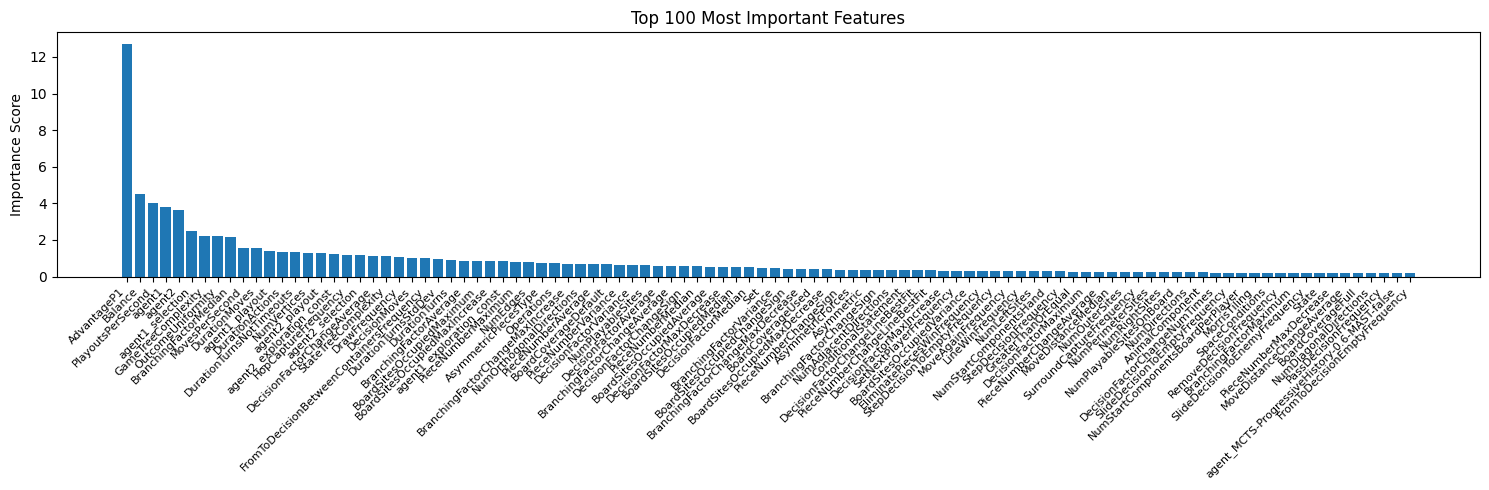

Fold 3 - RMSE: 0.425237873924711
Fold 4


0:	learn: 0.6032693	test: 0.5980558	best: 0.5980558 (0)	total: 88.7ms	remaining: 4m 25s


50:	learn: 0.3886225	test: 0.4832544	best: 0.4832544 (50)	total: 5.03s	remaining: 4m 51s


100:	learn: 0.3487498	test: 0.4615637	best: 0.4615637 (100)	total: 10.1s	remaining: 4m 49s


150:	learn: 0.3265542	test: 0.4549231	best: 0.4549231 (150)	total: 15.1s	remaining: 4m 45s


200:	learn: 0.3114365	test: 0.4517372	best: 0.4517372 (200)	total: 20.3s	remaining: 4m 42s


250:	learn: 0.2994459	test: 0.4488455	best: 0.4488010 (249)	total: 25.5s	remaining: 4m 39s


300:	learn: 0.2899351	test: 0.4477602	best: 0.4476917 (297)	total: 30.7s	remaining: 4m 35s


350:	learn: 0.2819632	test: 0.4464340	best: 0.4464340 (350)	total: 35.9s	remaining: 4m 31s


400:	learn: 0.2751068	test: 0.4450036	best: 0.4450036 (400)	total: 41s	remaining: 4m 25s


450:	learn: 0.2686589	test: 0.4443687	best: 0.4442643 (445)	total: 46.2s	remaining: 4m 21s


500:	learn: 0.2631125	test: 0.4437345	best: 0.4436757 (491)	total: 51.4s	remaining: 4m 16s


550:	learn: 0.2581996	test: 0.4429759	best: 0.4429449 (549)	total: 56.4s	remaining: 4m 10s


600:	learn: 0.2536648	test: 0.4424473	best: 0.4424473 (600)	total: 1m 1s	remaining: 4m 6s


650:	learn: 0.2493612	test: 0.4421975	best: 0.4421708 (649)	total: 1m 6s	remaining: 4m


700:	learn: 0.2457126	test: 0.4419094	best: 0.4419094 (700)	total: 1m 11s	remaining: 3m 56s


750:	learn: 0.2424000	test: 0.4416581	best: 0.4416156 (738)	total: 1m 17s	remaining: 3m 51s


800:	learn: 0.2391101	test: 0.4412671	best: 0.4412671 (800)	total: 1m 22s	remaining: 3m 46s


850:	learn: 0.2358979	test: 0.4410520	best: 0.4410520 (850)	total: 1m 27s	remaining: 3m 41s


900:	learn: 0.2331271	test: 0.4411203	best: 0.4410146 (854)	total: 1m 32s	remaining: 3m 36s


950:	learn: 0.2305498	test: 0.4408711	best: 0.4408711 (950)	total: 1m 37s	remaining: 3m 30s


1000:	learn: 0.2280067	test: 0.4405437	best: 0.4405437 (1000)	total: 1m 43s	remaining: 3m 25s


1050:	learn: 0.2255463	test: 0.4402067	best: 0.4401974 (1049)	total: 1m 48s	remaining: 3m 20s


1100:	learn: 0.2232054	test: 0.4400093	best: 0.4400093 (1100)	total: 1m 53s	remaining: 3m 15s


1150:	learn: 0.2208850	test: 0.4396771	best: 0.4396743 (1149)	total: 1m 58s	remaining: 3m 10s


1200:	learn: 0.2186366	test: 0.4395328	best: 0.4395008 (1182)	total: 2m 3s	remaining: 3m 5s


1250:	learn: 0.2165846	test: 0.4394980	best: 0.4394467 (1220)	total: 2m 9s	remaining: 3m


1300:	learn: 0.2145343	test: 0.4394656	best: 0.4394183 (1262)	total: 2m 14s	remaining: 2m 55s


1350:	learn: 0.2123023	test: 0.4394103	best: 0.4393972 (1342)	total: 2m 19s	remaining: 2m 50s


1400:	learn: 0.2102544	test: 0.4392213	best: 0.4392209 (1398)	total: 2m 24s	remaining: 2m 45s


1450:	learn: 0.2084895	test: 0.4391550	best: 0.4391191 (1425)	total: 2m 30s	remaining: 2m 40s


1500:	learn: 0.2067136	test: 0.4390261	best: 0.4390261 (1500)	total: 2m 35s	remaining: 2m 35s


1550:	learn: 0.2047895	test: 0.4387788	best: 0.4387788 (1550)	total: 2m 40s	remaining: 2m 29s


1600:	learn: 0.2030282	test: 0.4387116	best: 0.4387116 (1600)	total: 2m 45s	remaining: 2m 24s


1650:	learn: 0.2015192	test: 0.4386332	best: 0.4386278 (1622)	total: 2m 50s	remaining: 2m 19s


1700:	learn: 0.1998199	test: 0.4385214	best: 0.4385208 (1699)	total: 2m 55s	remaining: 2m 14s


1750:	learn: 0.1981692	test: 0.4385501	best: 0.4385208 (1699)	total: 3m 1s	remaining: 2m 9s


1800:	learn: 0.1967225	test: 0.4383983	best: 0.4383983 (1800)	total: 3m 6s	remaining: 2m 4s


1850:	learn: 0.1953825	test: 0.4383664	best: 0.4383634 (1833)	total: 3m 11s	remaining: 1m 59s


1900:	learn: 0.1938868	test: 0.4382959	best: 0.4382766 (1887)	total: 3m 16s	remaining: 1m 53s


1950:	learn: 0.1924491	test: 0.4383094	best: 0.4382766 (1887)	total: 3m 21s	remaining: 1m 48s


2000:	learn: 0.1910305	test: 0.4382567	best: 0.4382382 (1995)	total: 3m 27s	remaining: 1m 43s


2050:	learn: 0.1896287	test: 0.4382739	best: 0.4382382 (1995)	total: 3m 32s	remaining: 1m 38s


2100:	learn: 0.1883078	test: 0.4382664	best: 0.4382382 (1995)	total: 3m 37s	remaining: 1m 33s


2150:	learn: 0.1868960	test: 0.4382371	best: 0.4382159 (2123)	total: 3m 42s	remaining: 1m 27s


2200:	learn: 0.1854815	test: 0.4380670	best: 0.4380670 (2200)	total: 3m 47s	remaining: 1m 22s


2250:	learn: 0.1840471	test: 0.4380824	best: 0.4380352 (2238)	total: 3m 52s	remaining: 1m 17s


2300:	learn: 0.1828567	test: 0.4380273	best: 0.4379993 (2295)	total: 3m 58s	remaining: 1m 12s


2350:	learn: 0.1817226	test: 0.4380025	best: 0.4379948 (2344)	total: 4m 3s	remaining: 1m 7s


2400:	learn: 0.1804410	test: 0.4379675	best: 0.4379604 (2399)	total: 4m 8s	remaining: 1m 2s


2450:	learn: 0.1791632	test: 0.4379918	best: 0.4379528 (2416)	total: 4m 13s	remaining: 56.9s


2500:	learn: 0.1780417	test: 0.4379501	best: 0.4379417 (2497)	total: 4m 18s	remaining: 51.7s


2550:	learn: 0.1768635	test: 0.4379470	best: 0.4379362 (2525)	total: 4m 24s	remaining: 46.5s


2600:	learn: 0.1756591	test: 0.4379535	best: 0.4379312 (2553)	total: 4m 29s	remaining: 41.3s


2650:	learn: 0.1743502	test: 0.4379444	best: 0.4379312 (2553)	total: 4m 34s	remaining: 36.1s


2700:	learn: 0.1732775	test: 0.4380093	best: 0.4379312 (2553)	total: 4m 39s	remaining: 30.9s


2750:	learn: 0.1721298	test: 0.4379813	best: 0.4379312 (2553)	total: 4m 44s	remaining: 25.8s


2800:	learn: 0.1710394	test: 0.4379701	best: 0.4379302 (2786)	total: 4m 49s	remaining: 20.6s


2850:	learn: 0.1699557	test: 0.4379417	best: 0.4379254 (2823)	total: 4m 54s	remaining: 15.4s


2900:	learn: 0.1689645	test: 0.4379130	best: 0.4379130 (2900)	total: 5m	remaining: 10.2s


2950:	learn: 0.1679310	test: 0.4379557	best: 0.4379000 (2905)	total: 5m 5s	remaining: 5.07s


2999:	learn: 0.1669317	test: 0.4378970	best: 0.4378937 (2995)	total: 5m 10s	remaining: 0us

bestTest = 0.4378937422
bestIteration = 2995

Shrink model to first 2996 iterations.


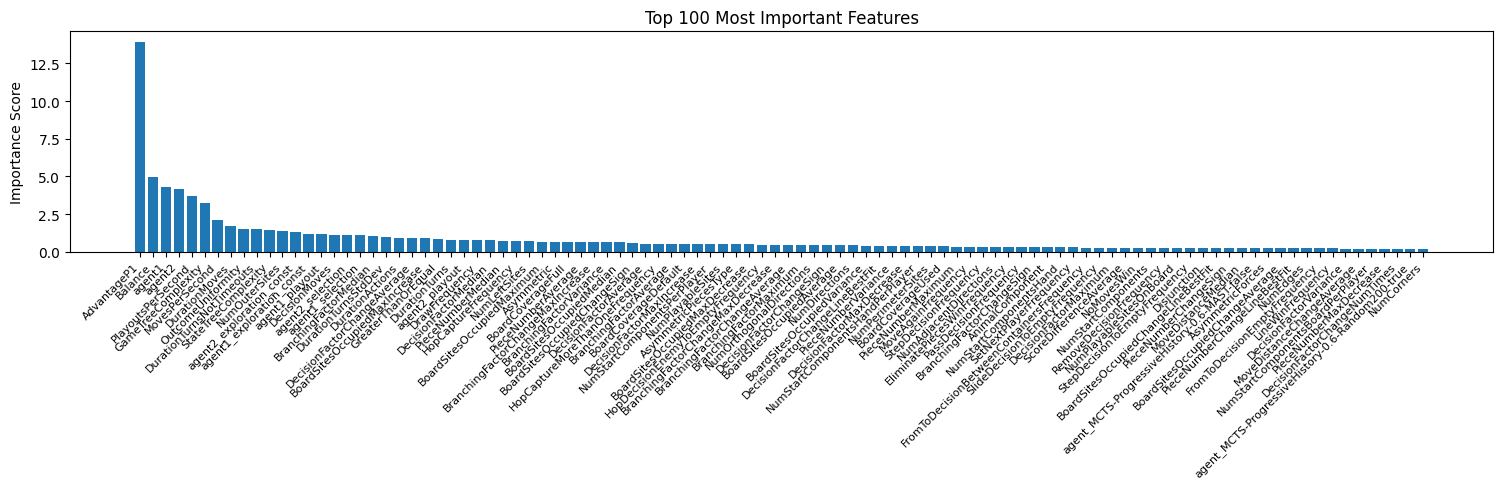

Fold 4 - RMSE: 0.43730396206534117
Fold 5


0:	learn: 0.6054755	test: 0.5857770	best: 0.5857770 (0)	total: 85.4ms	remaining: 4m 16s


50:	learn: 0.3816767	test: 0.4818127	best: 0.4818127 (50)	total: 4.89s	remaining: 4m 42s


100:	learn: 0.3448606	test: 0.4631373	best: 0.4631373 (100)	total: 9.99s	remaining: 4m 46s


150:	learn: 0.3234605	test: 0.4549753	best: 0.4549753 (150)	total: 15.1s	remaining: 4m 44s


200:	learn: 0.3083748	test: 0.4504609	best: 0.4504609 (200)	total: 20.1s	remaining: 4m 39s


250:	learn: 0.2964956	test: 0.4467673	best: 0.4467238 (246)	total: 25.1s	remaining: 4m 35s


300:	learn: 0.2866213	test: 0.4438462	best: 0.4438462 (300)	total: 30.3s	remaining: 4m 31s


350:	learn: 0.2792339	test: 0.4423649	best: 0.4423649 (350)	total: 35.5s	remaining: 4m 27s


400:	learn: 0.2718814	test: 0.4405639	best: 0.4405639 (400)	total: 40.7s	remaining: 4m 23s


450:	learn: 0.2661684	test: 0.4400174	best: 0.4400174 (450)	total: 45.8s	remaining: 4m 18s


500:	learn: 0.2607110	test: 0.4389951	best: 0.4389951 (500)	total: 50.9s	remaining: 4m 13s


550:	learn: 0.2557367	test: 0.4380708	best: 0.4380708 (550)	total: 56s	remaining: 4m 8s


600:	learn: 0.2514354	test: 0.4377666	best: 0.4377072 (598)	total: 1m 1s	remaining: 4m 4s


650:	learn: 0.2475574	test: 0.4371592	best: 0.4371572 (648)	total: 1m 6s	remaining: 3m 59s


700:	learn: 0.2433548	test: 0.4369444	best: 0.4368916 (690)	total: 1m 11s	remaining: 3m 54s


750:	learn: 0.2397005	test: 0.4363536	best: 0.4363378 (749)	total: 1m 16s	remaining: 3m 49s


800:	learn: 0.2363269	test: 0.4358518	best: 0.4358518 (800)	total: 1m 21s	remaining: 3m 44s


850:	learn: 0.2333657	test: 0.4354785	best: 0.4354349 (848)	total: 1m 26s	remaining: 3m 39s


900:	learn: 0.2305562	test: 0.4351895	best: 0.4351895 (900)	total: 1m 32s	remaining: 3m 34s


950:	learn: 0.2278843	test: 0.4348963	best: 0.4348887 (949)	total: 1m 37s	remaining: 3m 29s


1000:	learn: 0.2252167	test: 0.4349748	best: 0.4348219 (976)	total: 1m 42s	remaining: 3m 24s


1050:	learn: 0.2229495	test: 0.4349398	best: 0.4348219 (976)	total: 1m 47s	remaining: 3m 19s


1100:	learn: 0.2205117	test: 0.4347509	best: 0.4347496 (1099)	total: 1m 52s	remaining: 3m 14s


1150:	learn: 0.2181103	test: 0.4345640	best: 0.4345571 (1149)	total: 1m 57s	remaining: 3m 9s


1200:	learn: 0.2160827	test: 0.4343573	best: 0.4343529 (1198)	total: 2m 2s	remaining: 3m 4s


1250:	learn: 0.2138193	test: 0.4342593	best: 0.4342478 (1249)	total: 2m 7s	remaining: 2m 58s


1300:	learn: 0.2117467	test: 0.4340897	best: 0.4340858 (1299)	total: 2m 13s	remaining: 2m 53s


1350:	learn: 0.2099902	test: 0.4339267	best: 0.4339267 (1350)	total: 2m 18s	remaining: 2m 48s


1400:	learn: 0.2080772	test: 0.4337562	best: 0.4337562 (1400)	total: 2m 23s	remaining: 2m 43s


1450:	learn: 0.2063511	test: 0.4337394	best: 0.4337388 (1446)	total: 2m 28s	remaining: 2m 38s


1500:	learn: 0.2044831	test: 0.4336325	best: 0.4336325 (1500)	total: 2m 33s	remaining: 2m 33s


1550:	learn: 0.2027311	test: 0.4335838	best: 0.4335828 (1549)	total: 2m 38s	remaining: 2m 28s


1600:	learn: 0.2009852	test: 0.4335637	best: 0.4335531 (1588)	total: 2m 44s	remaining: 2m 23s


1650:	learn: 0.1992115	test: 0.4335713	best: 0.4335410 (1638)	total: 2m 49s	remaining: 2m 18s


1700:	learn: 0.1975547	test: 0.4334041	best: 0.4334041 (1700)	total: 2m 54s	remaining: 2m 13s


1750:	learn: 0.1959250	test: 0.4333534	best: 0.4333373 (1749)	total: 2m 59s	remaining: 2m 8s


1800:	learn: 0.1944418	test: 0.4333222	best: 0.4333174 (1792)	total: 3m 4s	remaining: 2m 2s


1850:	learn: 0.1927511	test: 0.4332402	best: 0.4332322 (1824)	total: 3m 9s	remaining: 1m 57s


1900:	learn: 0.1913035	test: 0.4331539	best: 0.4331198 (1878)	total: 3m 14s	remaining: 1m 52s


1950:	learn: 0.1897695	test: 0.4332114	best: 0.4331198 (1878)	total: 3m 20s	remaining: 1m 47s


2000:	learn: 0.1885129	test: 0.4332046	best: 0.4331198 (1878)	total: 3m 25s	remaining: 1m 42s


2050:	learn: 0.1871467	test: 0.4331049	best: 0.4330975 (2046)	total: 3m 30s	remaining: 1m 37s


2100:	learn: 0.1857462	test: 0.4330386	best: 0.4330375 (2099)	total: 3m 35s	remaining: 1m 32s


2150:	learn: 0.1843681	test: 0.4330493	best: 0.4330230 (2105)	total: 3m 40s	remaining: 1m 27s


2200:	learn: 0.1830125	test: 0.4329770	best: 0.4329712 (2186)	total: 3m 45s	remaining: 1m 21s


2250:	learn: 0.1816231	test: 0.4329708	best: 0.4329633 (2243)	total: 3m 51s	remaining: 1m 16s


2300:	learn: 0.1803731	test: 0.4329264	best: 0.4329167 (2292)	total: 3m 56s	remaining: 1m 11s


2350:	learn: 0.1791558	test: 0.4329405	best: 0.4328952 (2302)	total: 4m 1s	remaining: 1m 6s


2400:	learn: 0.1778234	test: 0.4329532	best: 0.4328952 (2302)	total: 4m 6s	remaining: 1m 1s


2450:	learn: 0.1766142	test: 0.4329546	best: 0.4328952 (2302)	total: 4m 11s	remaining: 56.4s


2500:	learn: 0.1754349	test: 0.4329958	best: 0.4328952 (2302)	total: 4m 16s	remaining: 51.3s


2550:	learn: 0.1741784	test: 0.4329473	best: 0.4328952 (2302)	total: 4m 22s	remaining: 46.1s


2600:	learn: 0.1730350	test: 0.4329839	best: 0.4328952 (2302)	total: 4m 27s	remaining: 41s


2650:	learn: 0.1717513	test: 0.4329785	best: 0.4328952 (2302)	total: 4m 32s	remaining: 35.9s


2700:	learn: 0.1705498	test: 0.4329834	best: 0.4328952 (2302)	total: 4m 37s	remaining: 30.7s


2750:	learn: 0.1694911	test: 0.4329936	best: 0.4328952 (2302)	total: 4m 42s	remaining: 25.6s


2800:	learn: 0.1685563	test: 0.4329572	best: 0.4328952 (2302)	total: 4m 47s	remaining: 20.5s


2850:	learn: 0.1674333	test: 0.4329928	best: 0.4328952 (2302)	total: 4m 53s	remaining: 15.3s


2900:	learn: 0.1663138	test: 0.4330594	best: 0.4328952 (2302)	total: 4m 58s	remaining: 10.2s


2950:	learn: 0.1652939	test: 0.4330395	best: 0.4328952 (2302)	total: 5m 3s	remaining: 5.04s


2999:	learn: 0.1642779	test: 0.4330484	best: 0.4328952 (2302)	total: 5m 8s	remaining: 0us

bestTest = 0.4328952306
bestIteration = 2302

Shrink model to first 2303 iterations.


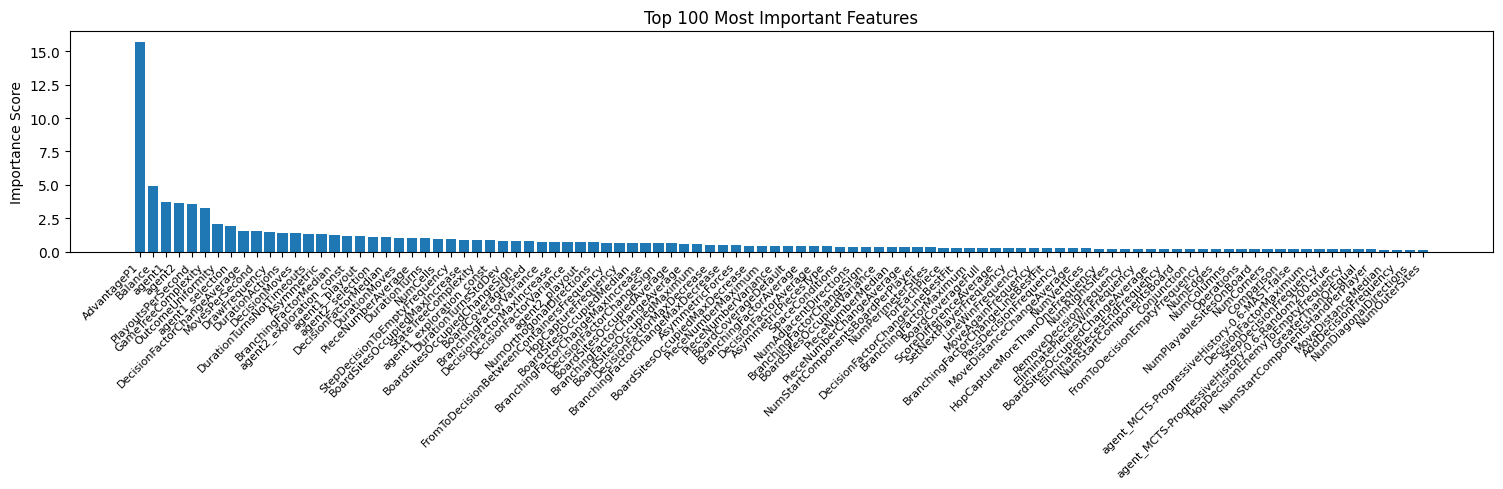

Fold 5 - RMSE: 0.43222113314503957
List of oof scores: [0.4110637674257878, 0.3999019902403095, 0.425237873924711, 0.43730396206534117, 0.43222113314503957]
Average oof score: 0.4211457453602378


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_catboost_{fs_type}_cv2.parquet', index=False)

Fold 1


0:	learn: 0.6100777	test: 0.5689084	best: 0.5689084 (0)	total: 85.3ms	remaining: 4m 15s


50:	learn: 0.3899257	test: 0.4668419	best: 0.4668419 (50)	total: 4.99s	remaining: 4m 48s


100:	learn: 0.3483279	test: 0.4498738	best: 0.4498738 (100)	total: 10.1s	remaining: 4m 50s


150:	learn: 0.3244053	test: 0.4416971	best: 0.4416733 (148)	total: 15.2s	remaining: 4m 46s


200:	learn: 0.3078008	test: 0.4380729	best: 0.4380729 (200)	total: 20.2s	remaining: 4m 41s


250:	learn: 0.2958056	test: 0.4354175	best: 0.4354175 (250)	total: 25.2s	remaining: 4m 36s


300:	learn: 0.2859428	test: 0.4334043	best: 0.4334043 (300)	total: 30.3s	remaining: 4m 31s


350:	learn: 0.2778502	test: 0.4324635	best: 0.4324635 (350)	total: 35.4s	remaining: 4m 27s


400:	learn: 0.2710713	test: 0.4315194	best: 0.4315194 (400)	total: 40.5s	remaining: 4m 22s


450:	learn: 0.2647260	test: 0.4304587	best: 0.4304495 (449)	total: 45.5s	remaining: 4m 17s


500:	learn: 0.2589270	test: 0.4298316	best: 0.4298004 (496)	total: 50.5s	remaining: 4m 11s


550:	learn: 0.2541633	test: 0.4294689	best: 0.4294280 (547)	total: 55.7s	remaining: 4m 7s


600:	learn: 0.2495622	test: 0.4291519	best: 0.4291519 (600)	total: 1m	remaining: 4m 2s


650:	learn: 0.2454054	test: 0.4289073	best: 0.4288560 (643)	total: 1m 5s	remaining: 3m 57s


700:	learn: 0.2413748	test: 0.4289040	best: 0.4288270 (654)	total: 1m 10s	remaining: 3m 52s


750:	learn: 0.2378786	test: 0.4286459	best: 0.4286459 (750)	total: 1m 16s	remaining: 3m 47s


800:	learn: 0.2348364	test: 0.4285453	best: 0.4285453 (800)	total: 1m 21s	remaining: 3m 42s


850:	learn: 0.2317719	test: 0.4283080	best: 0.4282975 (843)	total: 1m 26s	remaining: 3m 37s


900:	learn: 0.2289198	test: 0.4280211	best: 0.4280098 (889)	total: 1m 31s	remaining: 3m 32s


950:	learn: 0.2262299	test: 0.4277604	best: 0.4277604 (950)	total: 1m 36s	remaining: 3m 27s


1000:	learn: 0.2235994	test: 0.4275768	best: 0.4275526 (996)	total: 1m 41s	remaining: 3m 22s


1050:	learn: 0.2210337	test: 0.4274295	best: 0.4274137 (1032)	total: 1m 46s	remaining: 3m 17s


1100:	learn: 0.2187785	test: 0.4273833	best: 0.4273700 (1099)	total: 1m 51s	remaining: 3m 12s


1150:	learn: 0.2163995	test: 0.4272242	best: 0.4272087 (1145)	total: 1m 56s	remaining: 3m 7s


1200:	learn: 0.2143996	test: 0.4271182	best: 0.4271058 (1182)	total: 2m 1s	remaining: 3m 2s


1250:	learn: 0.2123386	test: 0.4270610	best: 0.4270414 (1239)	total: 2m 6s	remaining: 2m 57s


1300:	learn: 0.2104796	test: 0.4271186	best: 0.4270414 (1239)	total: 2m 11s	remaining: 2m 52s


1350:	learn: 0.2088690	test: 0.4271516	best: 0.4270414 (1239)	total: 2m 17s	remaining: 2m 47s


1400:	learn: 0.2072163	test: 0.4272394	best: 0.4270414 (1239)	total: 2m 22s	remaining: 2m 42s


1450:	learn: 0.2052726	test: 0.4271619	best: 0.4270414 (1239)	total: 2m 27s	remaining: 2m 37s


1500:	learn: 0.2035630	test: 0.4272665	best: 0.4270414 (1239)	total: 2m 32s	remaining: 2m 32s


1550:	learn: 0.2020442	test: 0.4271817	best: 0.4270414 (1239)	total: 2m 37s	remaining: 2m 27s


1600:	learn: 0.2002549	test: 0.4270002	best: 0.4269683 (1589)	total: 2m 42s	remaining: 2m 22s


1650:	learn: 0.1987097	test: 0.4270867	best: 0.4269683 (1589)	total: 2m 47s	remaining: 2m 17s


1700:	learn: 0.1971859	test: 0.4270598	best: 0.4269683 (1589)	total: 2m 53s	remaining: 2m 12s


1750:	learn: 0.1955354	test: 0.4270276	best: 0.4269683 (1589)	total: 2m 58s	remaining: 2m 7s


1800:	learn: 0.1940203	test: 0.4270028	best: 0.4269683 (1589)	total: 3m 3s	remaining: 2m 2s


1850:	learn: 0.1925198	test: 0.4269811	best: 0.4269607 (1843)	total: 3m 8s	remaining: 1m 56s


1900:	learn: 0.1910344	test: 0.4269351	best: 0.4269207 (1889)	total: 3m 13s	remaining: 1m 51s


1950:	learn: 0.1897155	test: 0.4268546	best: 0.4268385 (1933)	total: 3m 18s	remaining: 1m 46s


2000:	learn: 0.1881420	test: 0.4268829	best: 0.4268098 (1962)	total: 3m 23s	remaining: 1m 41s


2050:	learn: 0.1868749	test: 0.4268401	best: 0.4268098 (1962)	total: 3m 28s	remaining: 1m 36s


2100:	learn: 0.1855643	test: 0.4267909	best: 0.4267869 (2083)	total: 3m 33s	remaining: 1m 31s


2150:	learn: 0.1842655	test: 0.4268230	best: 0.4267580 (2120)	total: 3m 39s	remaining: 1m 26s


2200:	learn: 0.1829688	test: 0.4268252	best: 0.4267580 (2120)	total: 3m 44s	remaining: 1m 21s


2250:	learn: 0.1816385	test: 0.4268592	best: 0.4267580 (2120)	total: 3m 49s	remaining: 1m 16s


2300:	learn: 0.1804660	test: 0.4268358	best: 0.4267580 (2120)	total: 3m 54s	remaining: 1m 11s


2350:	learn: 0.1790819	test: 0.4268084	best: 0.4267580 (2120)	total: 3m 59s	remaining: 1m 6s


2400:	learn: 0.1779070	test: 0.4268149	best: 0.4267580 (2120)	total: 4m 4s	remaining: 1m 1s


2450:	learn: 0.1767669	test: 0.4267832	best: 0.4267580 (2120)	total: 4m 9s	remaining: 56s


2500:	learn: 0.1755416	test: 0.4267448	best: 0.4267426 (2499)	total: 4m 14s	remaining: 50.9s


2550:	learn: 0.1743585	test: 0.4266817	best: 0.4266605 (2548)	total: 4m 20s	remaining: 45.8s


2600:	learn: 0.1732662	test: 0.4266407	best: 0.4266407 (2600)	total: 4m 25s	remaining: 40.7s


2650:	learn: 0.1719930	test: 0.4266225	best: 0.4266225 (2650)	total: 4m 30s	remaining: 35.6s


2700:	learn: 0.1708268	test: 0.4265989	best: 0.4265887 (2689)	total: 4m 35s	remaining: 30.5s


2750:	learn: 0.1695967	test: 0.4265548	best: 0.4265535 (2746)	total: 4m 40s	remaining: 25.4s


2800:	learn: 0.1685410	test: 0.4265427	best: 0.4265378 (2798)	total: 4m 45s	remaining: 20.3s


2850:	learn: 0.1675019	test: 0.4266328	best: 0.4265251 (2804)	total: 4m 50s	remaining: 15.2s


2900:	learn: 0.1663797	test: 0.4266488	best: 0.4265251 (2804)	total: 4m 55s	remaining: 10.1s


2950:	learn: 0.1653999	test: 0.4266663	best: 0.4265251 (2804)	total: 5m	remaining: 5s


2999:	learn: 0.1643361	test: 0.4266228	best: 0.4265251 (2804)	total: 5m 5s	remaining: 0us

bestTest = 0.4265250658
bestIteration = 2804

Shrink model to first 2805 iterations.


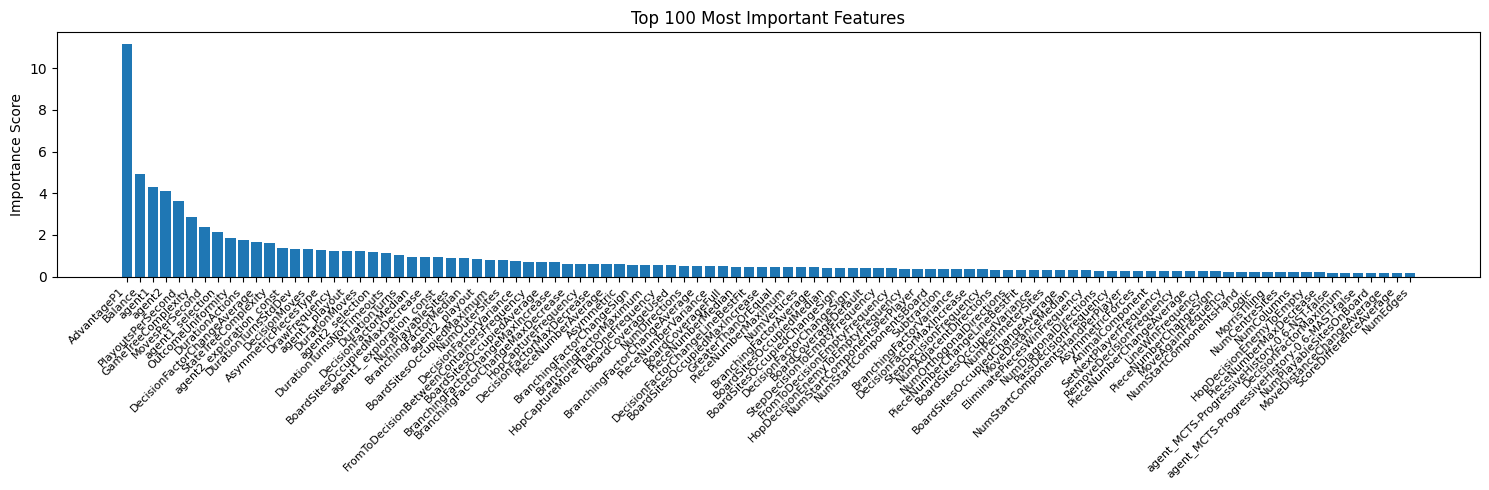

Fold 1 - RMSE: 0.42601759524005706
Fold 2


0:	learn: 0.6072406	test: 0.5712792	best: 0.5712792 (0)	total: 94.5ms	remaining: 4m 43s


50:	learn: 0.3879989	test: 0.4665437	best: 0.4665437 (50)	total: 4.96s	remaining: 4m 47s


100:	learn: 0.3491241	test: 0.4445337	best: 0.4445337 (100)	total: 10.1s	remaining: 4m 49s


150:	learn: 0.3263397	test: 0.4355813	best: 0.4355813 (150)	total: 15.1s	remaining: 4m 44s


200:	learn: 0.3088364	test: 0.4305408	best: 0.4305408 (200)	total: 20.2s	remaining: 4m 41s


250:	learn: 0.2974697	test: 0.4271718	best: 0.4271718 (250)	total: 25.4s	remaining: 4m 37s


300:	learn: 0.2879455	test: 0.4255370	best: 0.4255370 (300)	total: 30.6s	remaining: 4m 34s


350:	learn: 0.2796014	test: 0.4234481	best: 0.4234481 (350)	total: 35.7s	remaining: 4m 29s


400:	learn: 0.2728770	test: 0.4218202	best: 0.4217957 (398)	total: 41s	remaining: 4m 25s


450:	learn: 0.2669581	test: 0.4205477	best: 0.4205477 (450)	total: 46.1s	remaining: 4m 20s


500:	learn: 0.2617018	test: 0.4197206	best: 0.4197206 (500)	total: 51.2s	remaining: 4m 15s


550:	learn: 0.2562502	test: 0.4189806	best: 0.4189806 (550)	total: 56.2s	remaining: 4m 9s


600:	learn: 0.2514564	test: 0.4180145	best: 0.4180145 (600)	total: 1m 1s	remaining: 4m 4s


650:	learn: 0.2476413	test: 0.4176024	best: 0.4175898 (648)	total: 1m 6s	remaining: 3m 59s


700:	learn: 0.2438066	test: 0.4172538	best: 0.4172471 (692)	total: 1m 11s	remaining: 3m 54s


750:	learn: 0.2405267	test: 0.4167773	best: 0.4167773 (750)	total: 1m 16s	remaining: 3m 49s


800:	learn: 0.2372368	test: 0.4163759	best: 0.4163434 (796)	total: 1m 21s	remaining: 3m 44s


850:	learn: 0.2340523	test: 0.4162798	best: 0.4162780 (849)	total: 1m 26s	remaining: 3m 39s


900:	learn: 0.2309597	test: 0.4161358	best: 0.4161358 (900)	total: 1m 32s	remaining: 3m 34s


950:	learn: 0.2283366	test: 0.4160301	best: 0.4160271 (947)	total: 1m 37s	remaining: 3m 29s


1000:	learn: 0.2258343	test: 0.4157603	best: 0.4157553 (999)	total: 1m 42s	remaining: 3m 24s


1050:	learn: 0.2233886	test: 0.4156294	best: 0.4156294 (1050)	total: 1m 47s	remaining: 3m 19s


1100:	learn: 0.2211365	test: 0.4154150	best: 0.4154150 (1100)	total: 1m 52s	remaining: 3m 14s


1150:	learn: 0.2187018	test: 0.4150965	best: 0.4150958 (1149)	total: 1m 57s	remaining: 3m 9s


1200:	learn: 0.2164552	test: 0.4149879	best: 0.4149721 (1182)	total: 2m 2s	remaining: 3m 4s


1250:	learn: 0.2140999	test: 0.4145873	best: 0.4145832 (1247)	total: 2m 8s	remaining: 2m 58s


1300:	learn: 0.2119754	test: 0.4146034	best: 0.4145350 (1258)	total: 2m 13s	remaining: 2m 53s


1350:	learn: 0.2100692	test: 0.4145099	best: 0.4145099 (1350)	total: 2m 18s	remaining: 2m 48s


1400:	learn: 0.2082043	test: 0.4143185	best: 0.4143185 (1400)	total: 2m 23s	remaining: 2m 43s


1450:	learn: 0.2064654	test: 0.4143872	best: 0.4142923 (1411)	total: 2m 28s	remaining: 2m 38s


1500:	learn: 0.2047118	test: 0.4141889	best: 0.4141701 (1491)	total: 2m 33s	remaining: 2m 33s


1550:	learn: 0.2029675	test: 0.4140275	best: 0.4140202 (1549)	total: 2m 39s	remaining: 2m 28s


1600:	learn: 0.2014026	test: 0.4139603	best: 0.4139160 (1585)	total: 2m 44s	remaining: 2m 23s


1650:	learn: 0.1998467	test: 0.4138888	best: 0.4138888 (1650)	total: 2m 49s	remaining: 2m 18s


1700:	learn: 0.1982224	test: 0.4138017	best: 0.4137803 (1679)	total: 2m 54s	remaining: 2m 13s


1750:	learn: 0.1966260	test: 0.4137183	best: 0.4137096 (1745)	total: 2m 59s	remaining: 2m 8s


1800:	learn: 0.1950547	test: 0.4137975	best: 0.4137096 (1745)	total: 3m 4s	remaining: 2m 3s


1850:	learn: 0.1935655	test: 0.4137751	best: 0.4137096 (1745)	total: 3m 9s	remaining: 1m 57s


1900:	learn: 0.1920634	test: 0.4137470	best: 0.4136961 (1868)	total: 3m 15s	remaining: 1m 52s


1950:	learn: 0.1907195	test: 0.4136758	best: 0.4136522 (1945)	total: 3m 20s	remaining: 1m 47s


2000:	learn: 0.1892201	test: 0.4136283	best: 0.4136267 (1999)	total: 3m 25s	remaining: 1m 42s


2050:	learn: 0.1878818	test: 0.4135652	best: 0.4135652 (2050)	total: 3m 30s	remaining: 1m 37s


2100:	learn: 0.1863527	test: 0.4135356	best: 0.4135166 (2058)	total: 3m 35s	remaining: 1m 32s


2150:	learn: 0.1851333	test: 0.4134606	best: 0.4134606 (2150)	total: 3m 40s	remaining: 1m 27s


2200:	learn: 0.1837908	test: 0.4134231	best: 0.4134166 (2199)	total: 3m 45s	remaining: 1m 22s


2250:	learn: 0.1825037	test: 0.4134243	best: 0.4134155 (2230)	total: 3m 51s	remaining: 1m 16s


2300:	learn: 0.1812434	test: 0.4134141	best: 0.4133937 (2275)	total: 3m 56s	remaining: 1m 11s


2350:	learn: 0.1799639	test: 0.4133614	best: 0.4133465 (2346)	total: 4m 1s	remaining: 1m 6s


2400:	learn: 0.1788234	test: 0.4132592	best: 0.4132591 (2399)	total: 4m 6s	remaining: 1m 1s


2450:	learn: 0.1775082	test: 0.4132662	best: 0.4132521 (2401)	total: 4m 11s	remaining: 56.4s


2500:	learn: 0.1762837	test: 0.4132662	best: 0.4132491 (2462)	total: 4m 16s	remaining: 51.3s


2550:	learn: 0.1750790	test: 0.4132675	best: 0.4132491 (2462)	total: 4m 22s	remaining: 46.1s


2600:	learn: 0.1739928	test: 0.4132064	best: 0.4131963 (2594)	total: 4m 27s	remaining: 41s


2650:	learn: 0.1728640	test: 0.4131737	best: 0.4131701 (2633)	total: 4m 32s	remaining: 35.9s


2700:	learn: 0.1715639	test: 0.4131394	best: 0.4131350 (2682)	total: 4m 37s	remaining: 30.7s


2750:	learn: 0.1704848	test: 0.4131977	best: 0.4131340 (2725)	total: 4m 42s	remaining: 25.6s


2800:	learn: 0.1694453	test: 0.4131859	best: 0.4131340 (2725)	total: 4m 47s	remaining: 20.4s


2850:	learn: 0.1684022	test: 0.4131995	best: 0.4131340 (2725)	total: 4m 52s	remaining: 15.3s


2900:	learn: 0.1672891	test: 0.4131825	best: 0.4131340 (2725)	total: 4m 57s	remaining: 10.2s


2950:	learn: 0.1662528	test: 0.4131720	best: 0.4131340 (2725)	total: 5m 3s	remaining: 5.03s


2999:	learn: 0.1652184	test: 0.4132327	best: 0.4131340 (2725)	total: 5m 8s	remaining: 0us

bestTest = 0.4131340218
bestIteration = 2725

Shrink model to first 2726 iterations.


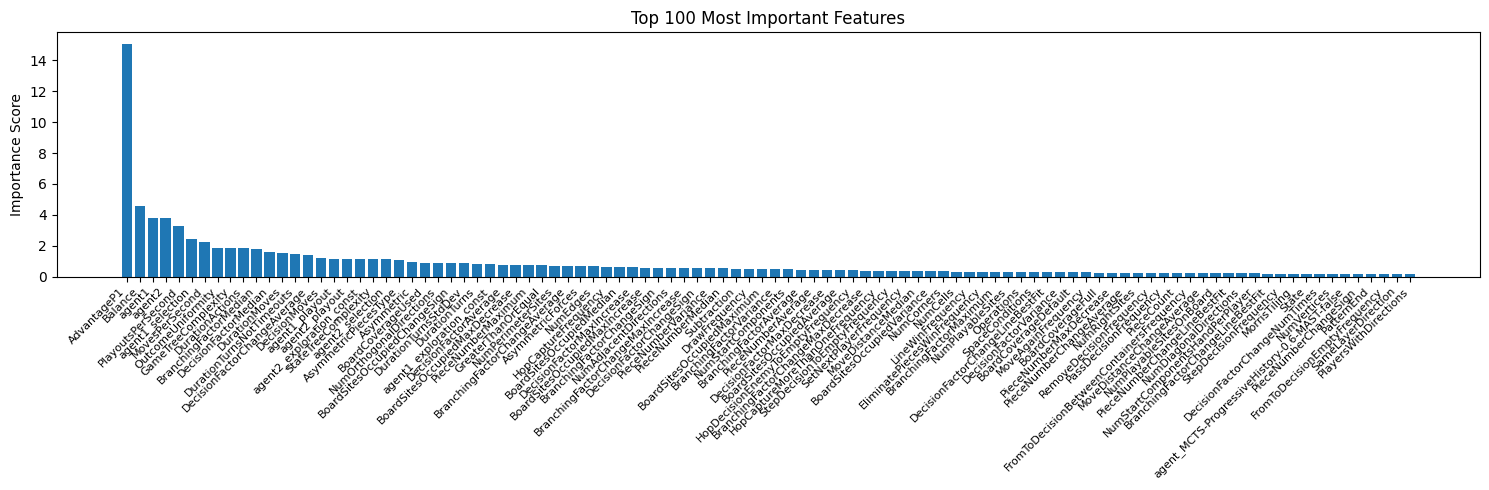

Fold 2 - RMSE: 0.4126259801308557
Fold 3


0:	learn: 0.6113273	test: 0.5689621	best: 0.5689621 (0)	total: 94.8ms	remaining: 4m 44s


50:	learn: 0.3879505	test: 0.4628839	best: 0.4628839 (50)	total: 4.88s	remaining: 4m 41s


100:	learn: 0.3493046	test: 0.4463211	best: 0.4463211 (100)	total: 9.86s	remaining: 4m 43s


150:	learn: 0.3259333	test: 0.4392090	best: 0.4392090 (150)	total: 14.7s	remaining: 4m 37s


200:	learn: 0.3106645	test: 0.4356722	best: 0.4356722 (200)	total: 19.6s	remaining: 4m 33s


250:	learn: 0.2986566	test: 0.4327778	best: 0.4327778 (250)	total: 24.5s	remaining: 4m 28s


300:	learn: 0.2895247	test: 0.4316307	best: 0.4316249 (298)	total: 29.5s	remaining: 4m 24s


350:	learn: 0.2809961	test: 0.4297990	best: 0.4297990 (350)	total: 34.4s	remaining: 4m 19s


400:	learn: 0.2737614	test: 0.4285828	best: 0.4285828 (400)	total: 39.3s	remaining: 4m 14s


450:	learn: 0.2673277	test: 0.4278492	best: 0.4278492 (450)	total: 44.2s	remaining: 4m 9s


500:	learn: 0.2619300	test: 0.4270703	best: 0.4270703 (500)	total: 49.1s	remaining: 4m 4s


550:	learn: 0.2564810	test: 0.4264412	best: 0.4264164 (539)	total: 54s	remaining: 3m 59s


600:	learn: 0.2521051	test: 0.4258189	best: 0.4257813 (592)	total: 59s	remaining: 3m 55s


650:	learn: 0.2474140	test: 0.4255338	best: 0.4255338 (650)	total: 1m 3s	remaining: 3m 50s


700:	learn: 0.2435200	test: 0.4251426	best: 0.4251175 (698)	total: 1m 9s	remaining: 3m 46s


750:	learn: 0.2399190	test: 0.4246497	best: 0.4246480 (749)	total: 1m 14s	remaining: 3m 41s


800:	learn: 0.2365658	test: 0.4243176	best: 0.4243176 (800)	total: 1m 18s	remaining: 3m 36s


850:	learn: 0.2331693	test: 0.4238169	best: 0.4237855 (845)	total: 1m 23s	remaining: 3m 31s


900:	learn: 0.2301785	test: 0.4237044	best: 0.4236783 (896)	total: 1m 28s	remaining: 3m 27s


950:	learn: 0.2273115	test: 0.4236684	best: 0.4236468 (937)	total: 1m 33s	remaining: 3m 22s


1000:	learn: 0.2245671	test: 0.4235950	best: 0.4235683 (996)	total: 1m 38s	remaining: 3m 17s


1050:	learn: 0.2219448	test: 0.4235240	best: 0.4234916 (1046)	total: 1m 43s	remaining: 3m 12s


1100:	learn: 0.2194005	test: 0.4233966	best: 0.4233643 (1097)	total: 1m 48s	remaining: 3m 7s


1150:	learn: 0.2170242	test: 0.4234262	best: 0.4233643 (1097)	total: 1m 53s	remaining: 3m 2s


1200:	learn: 0.2148019	test: 0.4233382	best: 0.4233181 (1188)	total: 1m 58s	remaining: 2m 57s


1250:	learn: 0.2126417	test: 0.4233655	best: 0.4233181 (1188)	total: 2m 3s	remaining: 2m 52s


1300:	learn: 0.2105938	test: 0.4232313	best: 0.4232305 (1293)	total: 2m 8s	remaining: 2m 47s


1350:	learn: 0.2085264	test: 0.4231896	best: 0.4231570 (1326)	total: 2m 13s	remaining: 2m 42s


1400:	learn: 0.2066341	test: 0.4231269	best: 0.4231269 (1400)	total: 2m 18s	remaining: 2m 38s


1450:	learn: 0.2047614	test: 0.4231299	best: 0.4230872 (1416)	total: 2m 23s	remaining: 2m 33s


1500:	learn: 0.2028536	test: 0.4230288	best: 0.4230271 (1491)	total: 2m 28s	remaining: 2m 28s


1550:	learn: 0.2010186	test: 0.4231034	best: 0.4230201 (1510)	total: 2m 33s	remaining: 2m 23s


1600:	learn: 0.1991945	test: 0.4231223	best: 0.4230201 (1510)	total: 2m 38s	remaining: 2m 18s


1650:	learn: 0.1973612	test: 0.4230442	best: 0.4230076 (1641)	total: 2m 43s	remaining: 2m 13s


1700:	learn: 0.1955777	test: 0.4230309	best: 0.4230076 (1641)	total: 2m 48s	remaining: 2m 8s


1750:	learn: 0.1940301	test: 0.4228882	best: 0.4228793 (1747)	total: 2m 53s	remaining: 2m 3s


1800:	learn: 0.1924211	test: 0.4229175	best: 0.4228695 (1757)	total: 2m 58s	remaining: 1m 58s


1850:	learn: 0.1907569	test: 0.4229121	best: 0.4228695 (1757)	total: 3m 2s	remaining: 1m 53s


1900:	learn: 0.1890531	test: 0.4228816	best: 0.4228695 (1757)	total: 3m 7s	remaining: 1m 48s


1950:	learn: 0.1875940	test: 0.4229101	best: 0.4228695 (1757)	total: 3m 12s	remaining: 1m 43s


2000:	learn: 0.1863671	test: 0.4229583	best: 0.4228695 (1757)	total: 3m 17s	remaining: 1m 38s


2050:	learn: 0.1848797	test: 0.4228577	best: 0.4228543 (2045)	total: 3m 22s	remaining: 1m 33s


2100:	learn: 0.1833816	test: 0.4228542	best: 0.4228310 (2075)	total: 3m 27s	remaining: 1m 28s


2150:	learn: 0.1819048	test: 0.4228651	best: 0.4228190 (2118)	total: 3m 32s	remaining: 1m 24s


2200:	learn: 0.1806440	test: 0.4228756	best: 0.4228190 (2118)	total: 3m 38s	remaining: 1m 19s


2250:	learn: 0.1792850	test: 0.4228559	best: 0.4228190 (2118)	total: 3m 43s	remaining: 1m 14s


2300:	learn: 0.1779829	test: 0.4228071	best: 0.4228071 (2300)	total: 3m 48s	remaining: 1m 9s


2350:	learn: 0.1767633	test: 0.4227700	best: 0.4227700 (2350)	total: 3m 53s	remaining: 1m 4s


2400:	learn: 0.1754477	test: 0.4227920	best: 0.4227568 (2357)	total: 3m 58s	remaining: 59.4s


2450:	learn: 0.1742813	test: 0.4227812	best: 0.4227371 (2430)	total: 4m 3s	remaining: 54.5s


2500:	learn: 0.1730066	test: 0.4227883	best: 0.4227371 (2430)	total: 4m 7s	remaining: 49.5s


2550:	learn: 0.1717635	test: 0.4227527	best: 0.4227371 (2430)	total: 4m 12s	remaining: 44.5s


2600:	learn: 0.1705955	test: 0.4227340	best: 0.4227247 (2599)	total: 4m 17s	remaining: 39.6s


2650:	learn: 0.1694319	test: 0.4227124	best: 0.4227056 (2625)	total: 4m 22s	remaining: 34.6s


2700:	learn: 0.1682794	test: 0.4227018	best: 0.4227018 (2700)	total: 4m 27s	remaining: 29.6s


2750:	learn: 0.1672925	test: 0.4227343	best: 0.4227017 (2701)	total: 4m 32s	remaining: 24.7s


2800:	learn: 0.1661138	test: 0.4227587	best: 0.4227017 (2701)	total: 4m 37s	remaining: 19.7s


2850:	learn: 0.1649664	test: 0.4226915	best: 0.4226915 (2850)	total: 4m 42s	remaining: 14.8s


2900:	learn: 0.1637843	test: 0.4226812	best: 0.4226707 (2876)	total: 4m 47s	remaining: 9.81s


2950:	learn: 0.1626382	test: 0.4227028	best: 0.4226663 (2919)	total: 4m 52s	remaining: 4.86s


2999:	learn: 0.1615835	test: 0.4226989	best: 0.4226663 (2919)	total: 4m 57s	remaining: 0us

bestTest = 0.4226663072
bestIteration = 2919

Shrink model to first 2920 iterations.


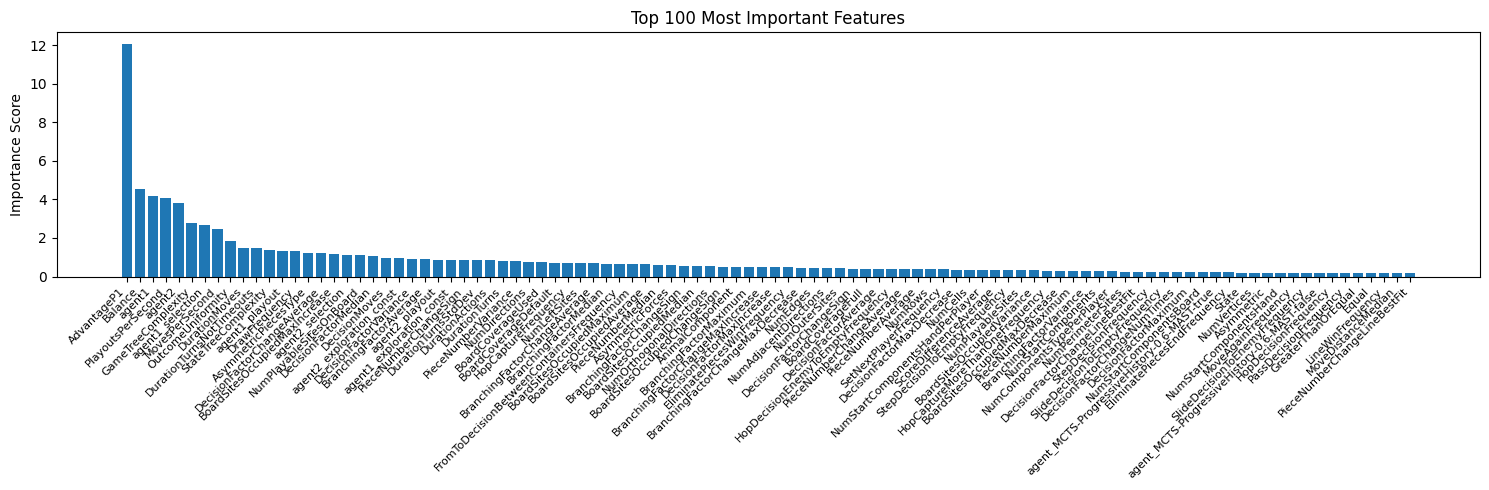

Fold 3 - RMSE: 0.4221023942859354
Fold 4


0:	learn: 0.6106799	test: 0.5687025	best: 0.5687025 (0)	total: 87.8ms	remaining: 4m 23s


50:	learn: 0.3858675	test: 0.4558873	best: 0.4558873 (50)	total: 4.75s	remaining: 4m 34s


100:	learn: 0.3477672	test: 0.4415017	best: 0.4415017 (100)	total: 9.64s	remaining: 4m 36s


150:	learn: 0.3248081	test: 0.4345953	best: 0.4345953 (150)	total: 14.5s	remaining: 4m 34s


200:	learn: 0.3087361	test: 0.4300925	best: 0.4300925 (200)	total: 19.4s	remaining: 4m 29s


250:	learn: 0.2954450	test: 0.4270962	best: 0.4270962 (250)	total: 24.2s	remaining: 4m 25s


300:	learn: 0.2869615	test: 0.4251423	best: 0.4251423 (300)	total: 29.2s	remaining: 4m 21s


350:	learn: 0.2790039	test: 0.4241785	best: 0.4241785 (350)	total: 34s	remaining: 4m 16s


400:	learn: 0.2717487	test: 0.4235928	best: 0.4235431 (397)	total: 38.9s	remaining: 4m 12s


450:	learn: 0.2656255	test: 0.4226115	best: 0.4226040 (449)	total: 43.9s	remaining: 4m 7s


500:	learn: 0.2605308	test: 0.4216725	best: 0.4216397 (499)	total: 48.8s	remaining: 4m 3s


550:	learn: 0.2552107	test: 0.4213205	best: 0.4213205 (550)	total: 53.7s	remaining: 3m 58s


600:	learn: 0.2506879	test: 0.4208165	best: 0.4208005 (598)	total: 58.6s	remaining: 3m 54s


650:	learn: 0.2465115	test: 0.4204853	best: 0.4204853 (650)	total: 1m 3s	remaining: 3m 49s


700:	learn: 0.2430733	test: 0.4200342	best: 0.4200342 (700)	total: 1m 8s	remaining: 3m 45s


750:	learn: 0.2393251	test: 0.4198910	best: 0.4198334 (737)	total: 1m 13s	remaining: 3m 40s


800:	learn: 0.2362121	test: 0.4196945	best: 0.4196945 (800)	total: 1m 18s	remaining: 3m 35s


850:	learn: 0.2334150	test: 0.4194710	best: 0.4194710 (850)	total: 1m 23s	remaining: 3m 31s


900:	learn: 0.2302780	test: 0.4194527	best: 0.4194527 (900)	total: 1m 28s	remaining: 3m 26s


950:	learn: 0.2278115	test: 0.4193455	best: 0.4193455 (950)	total: 1m 33s	remaining: 3m 21s


1000:	learn: 0.2251441	test: 0.4191019	best: 0.4191019 (1000)	total: 1m 38s	remaining: 3m 16s


1050:	learn: 0.2227919	test: 0.4189874	best: 0.4189858 (1049)	total: 1m 43s	remaining: 3m 12s


1100:	learn: 0.2203039	test: 0.4187350	best: 0.4187350 (1100)	total: 1m 48s	remaining: 3m 7s


1150:	learn: 0.2181355	test: 0.4185793	best: 0.4185579 (1143)	total: 1m 53s	remaining: 3m 2s


1200:	learn: 0.2158921	test: 0.4184730	best: 0.4184621 (1193)	total: 1m 58s	remaining: 2m 57s


1250:	learn: 0.2137656	test: 0.4184229	best: 0.4183937 (1226)	total: 2m 3s	remaining: 2m 52s


1300:	learn: 0.2118019	test: 0.4184951	best: 0.4183772 (1253)	total: 2m 8s	remaining: 2m 47s


1350:	learn: 0.2099141	test: 0.4184385	best: 0.4183772 (1253)	total: 2m 13s	remaining: 2m 42s


1400:	learn: 0.2079110	test: 0.4184325	best: 0.4183772 (1253)	total: 2m 18s	remaining: 2m 38s


1450:	learn: 0.2060630	test: 0.4184774	best: 0.4183772 (1253)	total: 2m 23s	remaining: 2m 33s


1500:	learn: 0.2043241	test: 0.4183882	best: 0.4183582 (1484)	total: 2m 28s	remaining: 2m 28s


1550:	learn: 0.2025467	test: 0.4182559	best: 0.4182559 (1550)	total: 2m 33s	remaining: 2m 23s


1600:	learn: 0.2007019	test: 0.4182782	best: 0.4182149 (1576)	total: 2m 38s	remaining: 2m 18s


1650:	learn: 0.1989148	test: 0.4182447	best: 0.4181938 (1621)	total: 2m 43s	remaining: 2m 13s


1700:	learn: 0.1973726	test: 0.4181596	best: 0.4181443 (1694)	total: 2m 48s	remaining: 2m 8s


1750:	learn: 0.1957244	test: 0.4180931	best: 0.4180668 (1740)	total: 2m 53s	remaining: 2m 4s


1800:	learn: 0.1942065	test: 0.4180526	best: 0.4180352 (1793)	total: 2m 59s	remaining: 1m 59s


1850:	learn: 0.1926776	test: 0.4179189	best: 0.4179189 (1850)	total: 3m 3s	remaining: 1m 54s


1900:	learn: 0.1912148	test: 0.4179263	best: 0.4178753 (1865)	total: 3m 9s	remaining: 1m 49s


1950:	learn: 0.1895978	test: 0.4178675	best: 0.4178675 (1950)	total: 3m 14s	remaining: 1m 44s


2000:	learn: 0.1881467	test: 0.4178612	best: 0.4178529 (1957)	total: 3m 18s	remaining: 1m 39s


2050:	learn: 0.1866964	test: 0.4178061	best: 0.4177948 (2027)	total: 3m 23s	remaining: 1m 34s


2100:	learn: 0.1852835	test: 0.4178376	best: 0.4177797 (2064)	total: 3m 28s	remaining: 1m 29s


2150:	learn: 0.1839322	test: 0.4178025	best: 0.4177778 (2141)	total: 3m 33s	remaining: 1m 24s


2200:	learn: 0.1826709	test: 0.4178262	best: 0.4177778 (2141)	total: 3m 38s	remaining: 1m 19s


2250:	learn: 0.1813478	test: 0.4178294	best: 0.4177778 (2141)	total: 3m 43s	remaining: 1m 14s


2300:	learn: 0.1801175	test: 0.4178554	best: 0.4177778 (2141)	total: 3m 48s	remaining: 1m 9s


2350:	learn: 0.1789002	test: 0.4178228	best: 0.4177778 (2141)	total: 3m 53s	remaining: 1m 4s


2400:	learn: 0.1776081	test: 0.4178775	best: 0.4177778 (2141)	total: 3m 58s	remaining: 59.6s


2450:	learn: 0.1763939	test: 0.4178616	best: 0.4177778 (2141)	total: 4m 3s	remaining: 54.6s


2500:	learn: 0.1751112	test: 0.4178089	best: 0.4177778 (2141)	total: 4m 8s	remaining: 49.7s


2550:	learn: 0.1739430	test: 0.4178299	best: 0.4177778 (2141)	total: 4m 13s	remaining: 44.7s


2600:	learn: 0.1728314	test: 0.4178136	best: 0.4177778 (2141)	total: 4m 18s	remaining: 39.7s


2650:	learn: 0.1716815	test: 0.4177643	best: 0.4177643 (2650)	total: 4m 23s	remaining: 34.7s


2700:	learn: 0.1704643	test: 0.4178016	best: 0.4177592 (2652)	total: 4m 28s	remaining: 29.8s


2750:	learn: 0.1692964	test: 0.4178120	best: 0.4177592 (2652)	total: 4m 33s	remaining: 24.8s


2800:	learn: 0.1681895	test: 0.4177751	best: 0.4177592 (2652)	total: 4m 38s	remaining: 19.8s


2850:	learn: 0.1671067	test: 0.4177422	best: 0.4177418 (2849)	total: 4m 43s	remaining: 14.8s


2900:	learn: 0.1660217	test: 0.4176932	best: 0.4176932 (2900)	total: 4m 48s	remaining: 9.85s


2950:	learn: 0.1649792	test: 0.4177103	best: 0.4176860 (2906)	total: 4m 53s	remaining: 4.88s


2999:	learn: 0.1638817	test: 0.4176756	best: 0.4176553 (2989)	total: 4m 58s	remaining: 0us

bestTest = 0.4176553082
bestIteration = 2989

Shrink model to first 2990 iterations.


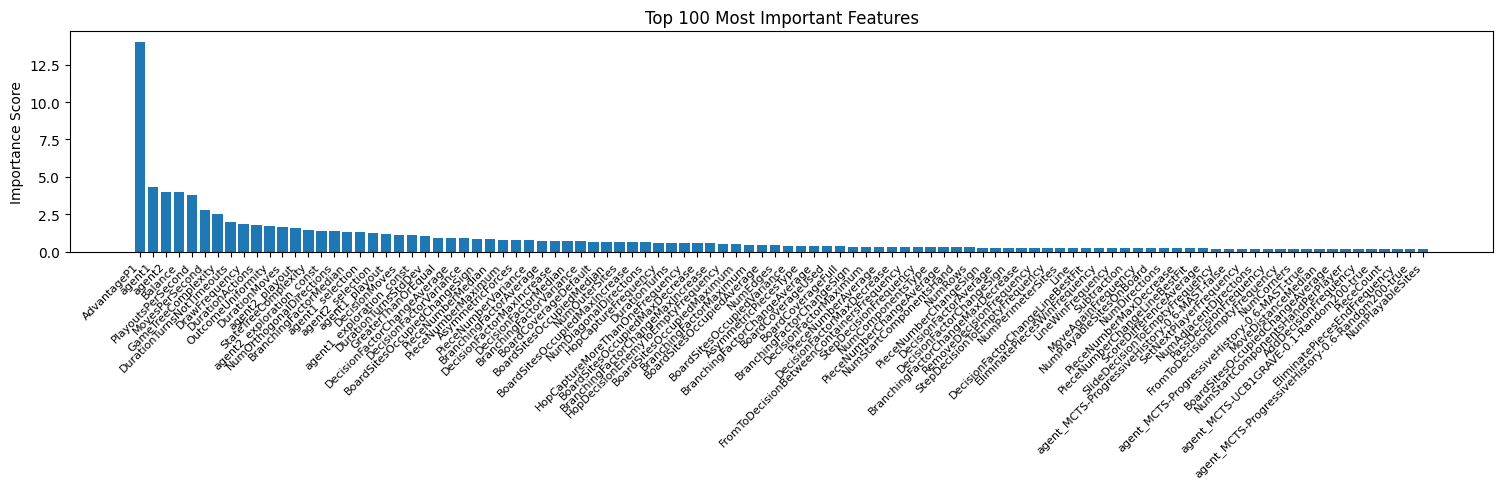

Fold 4 - RMSE: 0.41673713439551274
Fold 5


0:	learn: 0.6052822	test: 0.5796975	best: 0.5796975 (0)	total: 79.5ms	remaining: 3m 58s


50:	learn: 0.3872926	test: 0.4761032	best: 0.4761032 (50)	total: 4.99s	remaining: 4m 48s


100:	learn: 0.3478856	test: 0.4556271	best: 0.4556271 (100)	total: 10.1s	remaining: 4m 48s


150:	learn: 0.3244136	test: 0.4467420	best: 0.4467420 (150)	total: 15.1s	remaining: 4m 44s


200:	learn: 0.3089419	test: 0.4422370	best: 0.4422370 (200)	total: 20s	remaining: 4m 38s


250:	learn: 0.2973560	test: 0.4394304	best: 0.4394304 (250)	total: 25.1s	remaining: 4m 35s


300:	learn: 0.2873988	test: 0.4373169	best: 0.4372921 (299)	total: 30.1s	remaining: 4m 30s


350:	learn: 0.2793564	test: 0.4361669	best: 0.4361381 (343)	total: 35.1s	remaining: 4m 25s


400:	learn: 0.2722998	test: 0.4349769	best: 0.4349769 (400)	total: 40.3s	remaining: 4m 20s


450:	learn: 0.2660755	test: 0.4338095	best: 0.4338095 (450)	total: 45.4s	remaining: 4m 16s


500:	learn: 0.2607068	test: 0.4334410	best: 0.4333930 (496)	total: 50.5s	remaining: 4m 11s


550:	learn: 0.2556745	test: 0.4325342	best: 0.4325128 (548)	total: 55.6s	remaining: 4m 7s


600:	learn: 0.2511987	test: 0.4319290	best: 0.4319290 (600)	total: 1m	remaining: 4m 2s


650:	learn: 0.2472559	test: 0.4313452	best: 0.4313401 (640)	total: 1m 5s	remaining: 3m 57s


700:	learn: 0.2435975	test: 0.4308417	best: 0.4308417 (700)	total: 1m 10s	remaining: 3m 52s


750:	learn: 0.2401511	test: 0.4308519	best: 0.4307443 (707)	total: 1m 16s	remaining: 3m 47s


800:	learn: 0.2367419	test: 0.4305431	best: 0.4305431 (800)	total: 1m 21s	remaining: 3m 42s


850:	learn: 0.2337943	test: 0.4303720	best: 0.4303314 (845)	total: 1m 26s	remaining: 3m 37s


900:	learn: 0.2308467	test: 0.4301478	best: 0.4301314 (895)	total: 1m 31s	remaining: 3m 33s


950:	learn: 0.2281811	test: 0.4298978	best: 0.4298573 (946)	total: 1m 36s	remaining: 3m 28s


1000:	learn: 0.2253980	test: 0.4298637	best: 0.4297699 (969)	total: 1m 41s	remaining: 3m 23s


1050:	learn: 0.2226782	test: 0.4297067	best: 0.4296977 (1027)	total: 1m 46s	remaining: 3m 17s


1100:	learn: 0.2202625	test: 0.4296101	best: 0.4296004 (1092)	total: 1m 51s	remaining: 3m 13s


1150:	learn: 0.2181407	test: 0.4295545	best: 0.4295283 (1127)	total: 1m 57s	remaining: 3m 8s


1200:	learn: 0.2159004	test: 0.4294238	best: 0.4294238 (1200)	total: 2m 2s	remaining: 3m 3s


1250:	learn: 0.2137366	test: 0.4292126	best: 0.4291766 (1246)	total: 2m 7s	remaining: 2m 58s


1300:	learn: 0.2116473	test: 0.4289535	best: 0.4289528 (1299)	total: 2m 12s	remaining: 2m 53s


1350:	learn: 0.2096120	test: 0.4289134	best: 0.4288836 (1341)	total: 2m 17s	remaining: 2m 48s


1400:	learn: 0.2077329	test: 0.4288029	best: 0.4287801 (1390)	total: 2m 23s	remaining: 2m 43s


1450:	learn: 0.2059272	test: 0.4287295	best: 0.4287295 (1450)	total: 2m 28s	remaining: 2m 38s


1500:	learn: 0.2040974	test: 0.4285508	best: 0.4285508 (1500)	total: 2m 33s	remaining: 2m 33s


1550:	learn: 0.2023126	test: 0.4285695	best: 0.4284964 (1517)	total: 2m 38s	remaining: 2m 28s


1600:	learn: 0.2008017	test: 0.4285842	best: 0.4284964 (1517)	total: 2m 43s	remaining: 2m 23s


1650:	learn: 0.1990670	test: 0.4285533	best: 0.4284964 (1517)	total: 2m 49s	remaining: 2m 18s


1700:	learn: 0.1975599	test: 0.4285698	best: 0.4284964 (1517)	total: 2m 54s	remaining: 2m 13s


1750:	learn: 0.1958772	test: 0.4285104	best: 0.4284736 (1741)	total: 2m 59s	remaining: 2m 7s


1800:	learn: 0.1942944	test: 0.4284533	best: 0.4284209 (1798)	total: 3m 4s	remaining: 2m 2s


1850:	learn: 0.1928890	test: 0.4283597	best: 0.4283533 (1848)	total: 3m 9s	remaining: 1m 57s


1900:	learn: 0.1912575	test: 0.4283218	best: 0.4282926 (1897)	total: 3m 14s	remaining: 1m 52s


1950:	learn: 0.1897115	test: 0.4283289	best: 0.4282901 (1936)	total: 3m 19s	remaining: 1m 47s


2000:	learn: 0.1882526	test: 0.4283246	best: 0.4282901 (1936)	total: 3m 24s	remaining: 1m 42s


2050:	learn: 0.1869709	test: 0.4283341	best: 0.4282901 (1936)	total: 3m 30s	remaining: 1m 37s


2100:	learn: 0.1855845	test: 0.4283732	best: 0.4282901 (1936)	total: 3m 35s	remaining: 1m 32s


2150:	learn: 0.1841572	test: 0.4284234	best: 0.4282901 (1936)	total: 3m 40s	remaining: 1m 26s


2200:	learn: 0.1828191	test: 0.4283495	best: 0.4282901 (1936)	total: 3m 45s	remaining: 1m 21s


2250:	learn: 0.1815336	test: 0.4283296	best: 0.4282901 (1936)	total: 3m 50s	remaining: 1m 16s


2300:	learn: 0.1802466	test: 0.4283061	best: 0.4282771 (2265)	total: 3m 55s	remaining: 1m 11s


2350:	learn: 0.1789721	test: 0.4282698	best: 0.4282504 (2344)	total: 4m	remaining: 1m 6s


2400:	learn: 0.1776879	test: 0.4282491	best: 0.4282229 (2382)	total: 4m 5s	remaining: 1m 1s


2450:	learn: 0.1764399	test: 0.4282364	best: 0.4282051 (2432)	total: 4m 11s	remaining: 56.2s


2500:	learn: 0.1751576	test: 0.4282801	best: 0.4282051 (2432)	total: 4m 16s	remaining: 51.1s


2550:	learn: 0.1739747	test: 0.4282754	best: 0.4282051 (2432)	total: 4m 21s	remaining: 46s


2600:	learn: 0.1728724	test: 0.4282571	best: 0.4282051 (2432)	total: 4m 26s	remaining: 40.9s


2650:	learn: 0.1717671	test: 0.4282864	best: 0.4282051 (2432)	total: 4m 31s	remaining: 35.8s


2700:	learn: 0.1705671	test: 0.4282853	best: 0.4282051 (2432)	total: 4m 36s	remaining: 30.6s


2750:	learn: 0.1693469	test: 0.4282812	best: 0.4282051 (2432)	total: 4m 41s	remaining: 25.5s


2800:	learn: 0.1682553	test: 0.4282748	best: 0.4282051 (2432)	total: 4m 47s	remaining: 20.4s


2850:	learn: 0.1671640	test: 0.4282888	best: 0.4282051 (2432)	total: 4m 52s	remaining: 15.3s


2900:	learn: 0.1660139	test: 0.4283127	best: 0.4282051 (2432)	total: 4m 57s	remaining: 10.1s


2950:	learn: 0.1649812	test: 0.4282841	best: 0.4282051 (2432)	total: 5m 2s	remaining: 5.02s


2999:	learn: 0.1640305	test: 0.4282914	best: 0.4282051 (2432)	total: 5m 7s	remaining: 0us

bestTest = 0.4282050625
bestIteration = 2432

Shrink model to first 2433 iterations.


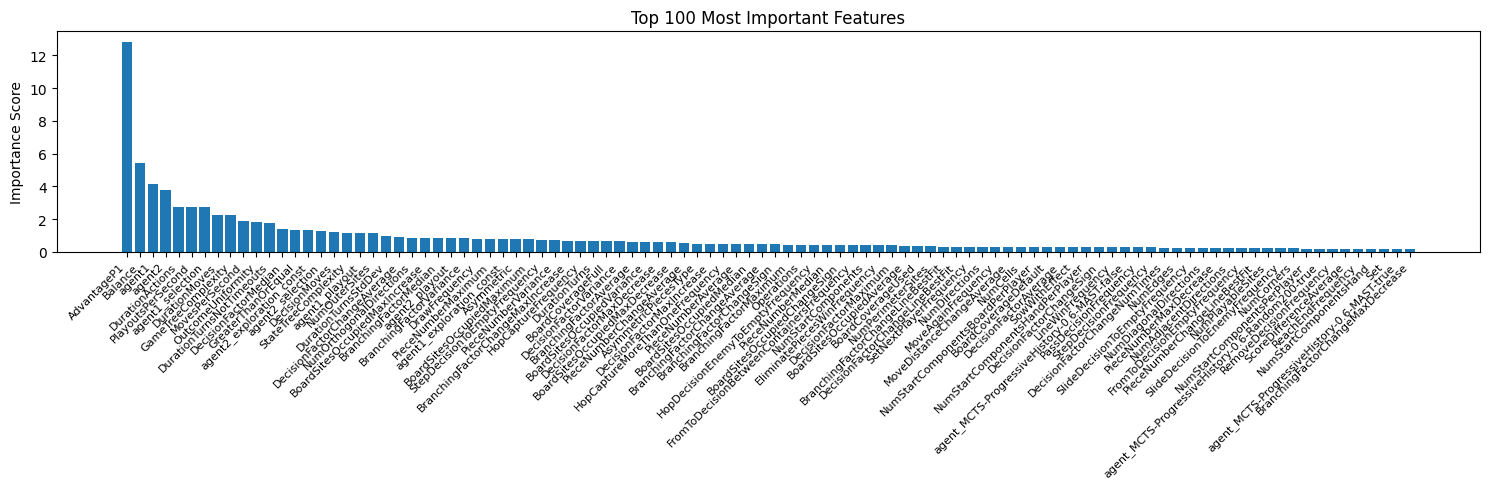

Fold 5 - RMSE: 0.4276212059732684
List of oof scores: [0.42601759524005706, 0.4126259801308557, 0.4221023942859354, 0.41673713439551274, 0.4276212059732684]
Average oof score: 0.4210208620051259


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_catboost_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")


CV1 OOF Scores:
Score: 0.4211
Score: 0.4311
Score: 0.4247
Score: 0.4332
Score: 0.4045
Average CV1 Score: 0.4229

CV2 OOF Scores:
Score: 0.4111
Score: 0.3999
Score: 0.4252
Score: 0.4373
Score: 0.4322
Average CV2 Score: 0.4211

CV3 OOF Scores:
Score: 0.4260
Score: 0.4126
Score: 0.4221
Score: 0.4167
Score: 0.4276
Average CV3 Score: 0.4210


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

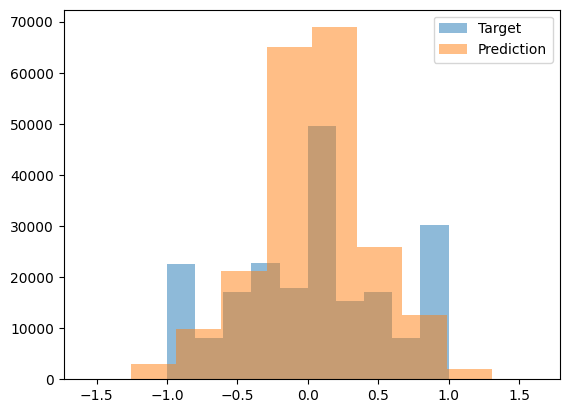

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        # data=test_processed[numerical_cols + categorical_cols + text_cols],
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols,
        # text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.135082       │
│ 233235 ┆ -0.158146      │
│ 233236 ┆ 0.008714       │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}
with open(f'./catboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***